In [12]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import joblib
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, f1_score, precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import time

import warnings
warnings.filterwarnings('ignore')

In [13]:
df = pd.read_csv('heart_cleaned.csv')

In [14]:
class FeatureCategorizer:
    def __init__(self, df):
        self.df = df.copy()
        self.continuous_features = []
        self.binary_features = []
        
    def categorize_features(self):
        """Automatically categorize features as continuous or binary"""
        print("Analyzing features...")
        print("="*50)
        
        for col in self.df.columns:
            unique_vals = self.df[col].nunique()
            is_numeric = pd.api.types.is_numeric_dtype(self.df[col])
            unique_values = sorted(self.df[col].unique())
            
            print(f"\n{col}:")
            print(f"  - Unique values: {unique_vals}")
            print(f"  - Is numeric: {is_numeric}")
            print(f"  - Sample values: {unique_values[:5] if len(unique_values) > 5 else unique_values}")
            
            if is_numeric:
                if unique_vals == 2 or set(self.df[col].unique()).issubset({0, 1, 0.0, 1.0}):
                    self.binary_features.append(col)
                    print(f"  → Classified as: BINARY")
                else:
                    self.continuous_features.append(col)
                    print(f"  → Classified as: CONTINUOUS")
            else:
                # Handle boolean or string binary features
                if unique_vals == 2:
                    self.binary_features.append(col)
                    print(f"  → Classified as: BINARY")
                else:
                    print(f"  → Classified as: OTHER (will be ignored)")
        
        print(f"\n{'='*50}")
        print("FINAL CATEGORIZATION:")
        print(f"{'='*50}")
        print(f"Continuous features ({len(self.continuous_features)}): {self.continuous_features}")
        print(f"Binary features ({len(self.binary_features)}): {self.binary_features}")
        
        return self.continuous_features, self.binary_features
    
    def get_feature_stats(self):
        """Get detailed statistics for each feature type"""
        print(f"\n{'='*50}")
        print("FEATURE STATISTICS:")
        print(f"{'='*50}")
        
        if self.continuous_features:
            print("\nCONTINUOUS FEATURES:")
            for feature in self.continuous_features:
                data = self.df[feature]
                print(f"\n{feature}:")
                print(f"  Mean: {data.mean():.2f}")
                print(f"  Std:  {data.std():.2f}")
                print(f"  Min:  {data.min():.2f}")
                print(f"  Max:  {data.max():.2f}")
                print(f"  Q1:   {data.quantile(0.25):.2f}")
                print(f"  Q3:   {data.quantile(0.75):.2f}")
        
        if self.binary_features:
            print("\nBINARY FEATURES:")
            for feature in self.binary_features:
                value_counts = self.df[feature].value_counts()
                print(f"\n{feature}:")
                for val, count in value_counts.items():
                    percentage = (count / len(self.df)) * 100
                    print(f"  {val}: {count} ({percentage:.1f}%)")

In [15]:
# Categorize features
categorizer = FeatureCategorizer(df)
continuous_features, binary_features = categorizer.categorize_features()

# Get detailed statistics
categorizer.get_feature_stats()

Analyzing features...

Age:
  - Unique values: 50
  - Is numeric: True
  - Sample values: [np.int64(28), np.int64(29), np.int64(30), np.int64(31), np.int64(32)]
  → Classified as: CONTINUOUS

Sex:
  - Unique values: 2
  - Is numeric: True
  - Sample values: [np.int64(0), np.int64(1)]
  → Classified as: BINARY

RestingBP:
  - Unique values: 67
  - Is numeric: True
  - Sample values: [np.int64(0), np.int64(80), np.int64(92), np.int64(94), np.int64(95)]
  → Classified as: CONTINUOUS

Cholesterol:
  - Unique values: 222
  - Is numeric: True
  - Sample values: [np.float64(85.0), np.float64(100.0), np.float64(110.0), np.float64(113.0), np.float64(117.0)]
  → Classified as: CONTINUOUS

FastingBS:
  - Unique values: 2
  - Is numeric: True
  - Sample values: [np.int64(0), np.int64(1)]
  → Classified as: BINARY

MaxHR:
  - Unique values: 119
  - Is numeric: True
  - Sample values: [np.int64(60), np.int64(63), np.int64(67), np.int64(69), np.int64(70)]
  → Classified as: CONTINUOUS

ExerciseAngina

In [ ]:
from sklearn.feature_selection import mutual_info_classif

X = df.drop('HeartDisease', axis=1)
Y = df['HeartDisease']

mutua_informazione_feature = []

def analyze_feature_information(X, Y, continuous_features, binary_features):
    """
    Calcola la mutua informazione media per feature numeriche e binarie.
    
    Args:
        X (pd.DataFrame): dataset delle feature
        y (pd.Series o array): target
        numerical_features (list): lista nomi delle feature numeriche
        binary_features (list): lista nomi delle feature binarie
    
    Returns:
        dict: valori medi di mutua informazione
    """
    # Calcolo mutua informazione per tutte le feature
    mi = mutual_info_classif(X, Y, discrete_features='auto', random_state=42)
    mi_df = pd.DataFrame({
        "feature": X.columns,
        "mutual_info": mi
    })
    
    # Separazione numeriche e binarie
    mi_numerical = mi_df[mi_df["feature"].isin(continuous_features)]["mutual_info"].mean()
    mi_binary = mi_df[mi_df["feature"].isin(binary_features)]["mutual_info"].mean()
    
    return {
        "MI_numerical": mi_numerical,
        "MI_binary": mi_binary
    }

ris = analyze_feature_information(X, Y, continuous_features, binary_features)
print(ris)

{'MI_numerical': np.float64(0.06646737346489448), 'MI_binary': np.float64(0.06725815612608918)}


In [ ]:
class ProgressiveOutlierGenerator:
    def __init__(self, df, continuous_features, pre_fitted_scaler=None, pre_fitted_pca=None):
        self.original_df = df.copy()
        self.current_df = df.copy()
        self.continuous_features = continuous_features
        self.contamination_history = []
        self.contaminated_values = set()
        
        # Calcola il numero totale di valori numerici
        self.total_numeric_values = len(df) * len(continuous_features)
        
        print(f"Initialized with:")
        print(f"  - Dataset size: {len(df)} samples")
        print(f"  - Continuous features: {len(continuous_features)}")
        print(f"  - Total numeric values: {self.total_numeric_values}")
        print(f"  - Mode: Individual value contamination")

    def add_continuous_outliers(self, contamination_rate=0.02, methods=['extreme'], seed=None):
        """Contamina singoli valori numerici"""
        rng = np.random.default_rng(seed)
        if not self.continuous_features:
            return {}

        univariate_methods = [m for m in methods if m != 'multivariate']
        if not univariate_methods:
            univariate_methods = ['extreme']

        # Calcola quanti nuovi valori contaminare
        n_new_outliers = int(round(self.total_numeric_values * contamination_rate))
        
        if n_new_outliers == 0 and contamination_rate > 0:
            n_new_outliers = 1

        # Genera tutte le possibili combinazioni (row_label, feature)
        all_value_positions = []
        for row_label in self.current_df.index:
            for feature in self.continuous_features:
                all_value_positions.append((row_label, feature))

        # Filtra quelle già contaminate
        available_positions = [pos for pos in all_value_positions 
                             if pos not in self.contaminated_values]

        if len(available_positions) == 0:
            print("No more clean values available for contamination.")
            return {}

        if len(available_positions) < n_new_outliers:
            n_new_outliers = len(available_positions)
            print(f"Warning: Only {len(available_positions)} clean values remaining. Using all of them.")

        # Scegli casualmente le posizioni da contaminare
        chosen_positions = rng.choice(len(available_positions), size=n_new_outliers, replace=False)
        chosen_positions = [available_positions[i] for i in chosen_positions]

        contamination_info = {}

        # Assicurati di poter ripristinare i valori originali
        if not hasattr(self, 'original_values'):
            self.original_values = {}

        for row_label, feature in chosen_positions:
            method = str(rng.choice(univariate_methods))

            # Salva il valore originale
            if row_label not in self.original_values:
                self.original_values[row_label] = {}
            if feature not in self.original_values[row_label]:
                self.original_values[row_label][feature] = self.current_df.at[row_label, feature]

            # Dati puliti: escludi valori già contaminati per questa feature
            clean_positions = [(rl, f) for rl, f in all_value_positions 
                             if f == feature and (rl, f) not in self.contaminated_values]
            clean_data = pd.Series([self.current_df.at[rl, f] for rl, f in clean_positions]).dropna()
            
            if clean_data.empty:
                continue

            q1, q3 = clean_data.quantile(0.25), clean_data.quantile(0.75)
            iqr = q3 - q1
            std_val = float(clean_data.std()) if clean_data.std() != 0 else 1.0
            min_val, max_val = clean_data.min(), clean_data.max()

            orig_val = float(self.current_df.at[row_label, feature])

            # Genera l'outlier
            if method == 'extreme':
                if rng.random() < 0.5:
                    outlier_val = q1 - rng.uniform(3, 6) * iqr
                    outlier_val = max(outlier_val, float(min_val) - 3 * std_val)
                else:
                    outlier_val = q3 + rng.uniform(3, 6) * iqr
                    outlier_val = min(outlier_val, float(max_val) + 3 * std_val)
            elif method == 'shift':
                shift_factor = rng.choice([-1, 1]) * rng.uniform(2, 4)
                outlier_val = orig_val + shift_factor * std_val
            elif method == 'noise':
                noise_factor = rng.choice([-1, 1]) * rng.uniform(3, 5)
                outlier_val = orig_val + noise_factor * std_val
            else:
                # fallback
                outlier_val = q3 + rng.uniform(3, 6) * iqr

            # Domain-aware clipping
            if feature in ['Age', 'RestingBP', 'Cholesterol', 'MaxHR']:
                lower_bound = 0
                outlier_val = max(outlier_val, lower_bound)

            # Preserva il tipo intero se necessario
            if pd.api.types.is_integer_dtype(self.current_df[feature].dtype):
                outlier_val = int(round(outlier_val))

            # Applica la modifica
            self.current_df.at[row_label, feature] = outlier_val

            # Registra l'informazione
            contamination_info.setdefault(feature, []).append({
                'index': row_label,
                'original_value': self.original_values[row_label][feature],
                'outlier_value': outlier_val,
                'method': method
            })

        # Aggiorna il set dei valori contaminati
        self.contaminated_values.update(set(chosen_positions))

        return contamination_info

    def progressive_contamination(self, steps=10, max_contamination=1, continuous_methods=['extreme', 'shift']):
        """Progressively contaminate individual numeric values in steps."""
        # Filtra i metodi univariati
        univariate_methods = [m for m in continuous_methods if m != 'multivariate']
        if not univariate_methods:
            print("No valid univariate methods provided. Using default methods.")
            univariate_methods = ['extreme', 'shift']
        
        contamination_rates = np.linspace(0, max_contamination, steps + 1)[1:]
        datasets = [self.original_df.copy()]
        
        print("Starting progressive contamination (individual values)...")
        print(f"Steps: {steps}")
        print(f"Methods: {univariate_methods}")
        print(f"Target contamination rates: {[f'{rate:.3f}' for rate in contamination_rates]}")
        print(f"Total numeric values to contaminate: {self.total_numeric_values}")
        
        for step, target_rate in enumerate(contamination_rates, 1):
            print(f"\n--- Step {step}/{steps}: Target contamination {target_rate:.3f} ---")
            
            current_contamination_rate = len(self.contaminated_values) / self.total_numeric_values
            incremental_rate = target_rate - current_contamination_rate
            
            if incremental_rate <= 0:
                print("Target contamination already reached or exceeded.")
                datasets.append(self.current_df.copy())
                continue
            
            print(f"Adding individual value outliers (incremental rate: {incremental_rate:.3f})...")
            cont_info = self.add_continuous_outliers(
                contamination_rate=incremental_rate,
                methods=univariate_methods
            )
            
            actual_contamination = len(self.contaminated_values) / self.total_numeric_values
            print(f"Actual total contamination: {actual_contamination:.3f}")
            print(f"Total contaminated values: {len(self.contaminated_values)}/{self.total_numeric_values}")
            
            self.contamination_history.append({
                'step': step,
                'target_rate': target_rate,
                'actual_rate': actual_contamination,
                'contaminated_values': len(self.contaminated_values),
                'continuous_info': cont_info,
            })
            
            datasets.append(self.current_df.copy())

            
            res = analyze_feature_information(self.current_df, Y, continuous_features, binary_features)
            res["perc_outliers"] = step / steps
            mutua_informazione_feature.append(res)
        
        return datasets, self.contamination_history

    def get_contamination_summary(self):
        """Print a detailed summary of contamination."""
        print(f"\n{'='*60}")
        print("CONTAMINATION SUMMARY (INDIVIDUAL VALUES)")
        print(f"{'='*60}")
        
        print(f"Original dataset size: {len(self.original_df)} samples")
        print(f"Continuous features: {len(self.continuous_features)}")
        print(f"Total numeric values: {self.total_numeric_values}")
        print(f"Total contaminated values: {len(self.contaminated_values)}")
        print(f"Overall contamination rate: {len(self.contaminated_values)/self.total_numeric_values:.3f}")
        
        # Conta contamination per feature
        feature_counts = {}
        for row_label, feature in self.contaminated_values:
            feature_counts[feature] = feature_counts.get(feature, 0) + 1
        
        print(f"\nContamination by feature:")
        for feature in self.continuous_features:
            count = feature_counts.get(feature, 0)
            total_feature_values = len(self.original_df)
            rate = count / total_feature_values if total_feature_values > 0 else 0
            print(f"  {feature}: {count}/{total_feature_values} values ({rate:.3f})")
        
        # Dettagli per step
        for i, history in enumerate(self.contamination_history, 1):
            print(f"\nStep {i}:")
            print(f"  Target rate: {history['target_rate']:.3f}")
            print(f"  Actual rate: {history['actual_rate']:.3f}")
            print(f"  Contaminated values: {history['contaminated_values']}")
            
            if history['continuous_info']:
                print("  New outliers by feature:")
                for feature, outliers in history['continuous_info'].items():
                    if outliers:
                        method_counts = {}
                        for outlier in outliers:
                            method = outlier['method']
                            method_counts[method] = method_counts.get(method, 0) + 1
                        
                        method_str = ", ".join([f"{method}: {count}" for method, count in method_counts.items()])
                        print(f"    {feature}: {len(outliers)} new outliers ({method_str})")

    def reset_to_clean(self):
        """Reset to original clean dataset."""
        self.current_df = self.original_df.copy()
        self.contaminated_values = set()
        self.contamination_history = []
        print("Dataset reset to original clean state.")
    
    def get_datasets(self):
        """Return both clean and current contaminated dataset."""
        return self.original_df.copy(), self.current_df.copy()
    
    def debug_outlier_counts(self):
        """Debug function to check outlier counts per feature and method"""
        print("\n" + "="*60)
        print("OUTLIER DEBUG INFORMATION (INDIVIDUAL VALUES)")
        print("="*60)
        
        print(f"Total contaminated values: {len(self.contaminated_values)}")
        print(f"Total numeric values: {self.total_numeric_values}")
        print(f"Overall contamination rate: {len(self.contaminated_values)/self.total_numeric_values:.3f}")
        
        feature_method_counts = {}
        for feature in self.continuous_features:
            feature_method_counts[feature] = {}
        
        for history in self.contamination_history:
            for feature, outliers in history['continuous_info'].items():
                for outlier_info in outliers:
                    method = outlier_info['method']
                    if method not in feature_method_counts[feature]:
                        feature_method_counts[feature][method] = 0
                    feature_method_counts[feature][method] += 1
        
        for feature in self.continuous_features:
            print(f"\n{feature}:")
            if feature_method_counts[feature]:
                total_feature_outliers = sum(feature_method_counts[feature].values())
                for method, count in feature_method_counts[feature].items():
                    print(f"  - {method} outliers: {count}")
                print(f"  - Total outliers: {total_feature_outliers}/{len(self.original_df)}")
                print(f"  - Feature contamination rate: {total_feature_outliers/len(self.original_df):.3f}")
            else:
                print(f"  - No outliers")

In [18]:
loaded_scaler = joblib.load('scaler.joblib')
loaded_pca = joblib.load('pca.joblib')

# Initialize the outlier generator with categorized features
generator = ProgressiveOutlierGenerator(df, continuous_features, pre_fitted_scaler=loaded_scaler, 
    pre_fitted_pca=loaded_pca)

# Generate progressive outliers
datasets, contamination_history = generator.progressive_contamination(
    steps=10,                          
    max_contamination=1,           
    continuous_methods=['extreme', 'shift', 'noise']  
)

# Print detailed summary
generator.get_contamination_summary()

Initialized with:
  - Dataset size: 918 samples
  - Continuous features: 5
  - Total numeric values: 4590
  - Mode: Individual value contamination
Starting progressive contamination (individual values)...
Steps: 10
Methods: ['extreme', 'shift', 'noise']
Target contamination rates: ['0.100', '0.200', '0.300', '0.400', '0.500', '0.600', '0.700', '0.800', '0.900', '1.000']
Total numeric values to contaminate: 4590

--- Step 1/10: Target contamination 0.100 ---
Adding individual value outliers (incremental rate: 0.100)...
Actual total contamination: 0.100
Total contaminated values: 459/4590

--- Step 2/10: Target contamination 0.200 ---
Adding individual value outliers (incremental rate: 0.100)...
Actual total contamination: 0.200
Total contaminated values: 918/4590

--- Step 3/10: Target contamination 0.300 ---
Adding individual value outliers (incremental rate: 0.100)...
Actual total contamination: 0.300
Total contaminated values: 1377/4590

--- Step 4/10: Target contamination 0.400 ---


Generating visualizations at specific contamination steps...
Total contamination steps: 10
Steps to visualize: [2, 5, 9]


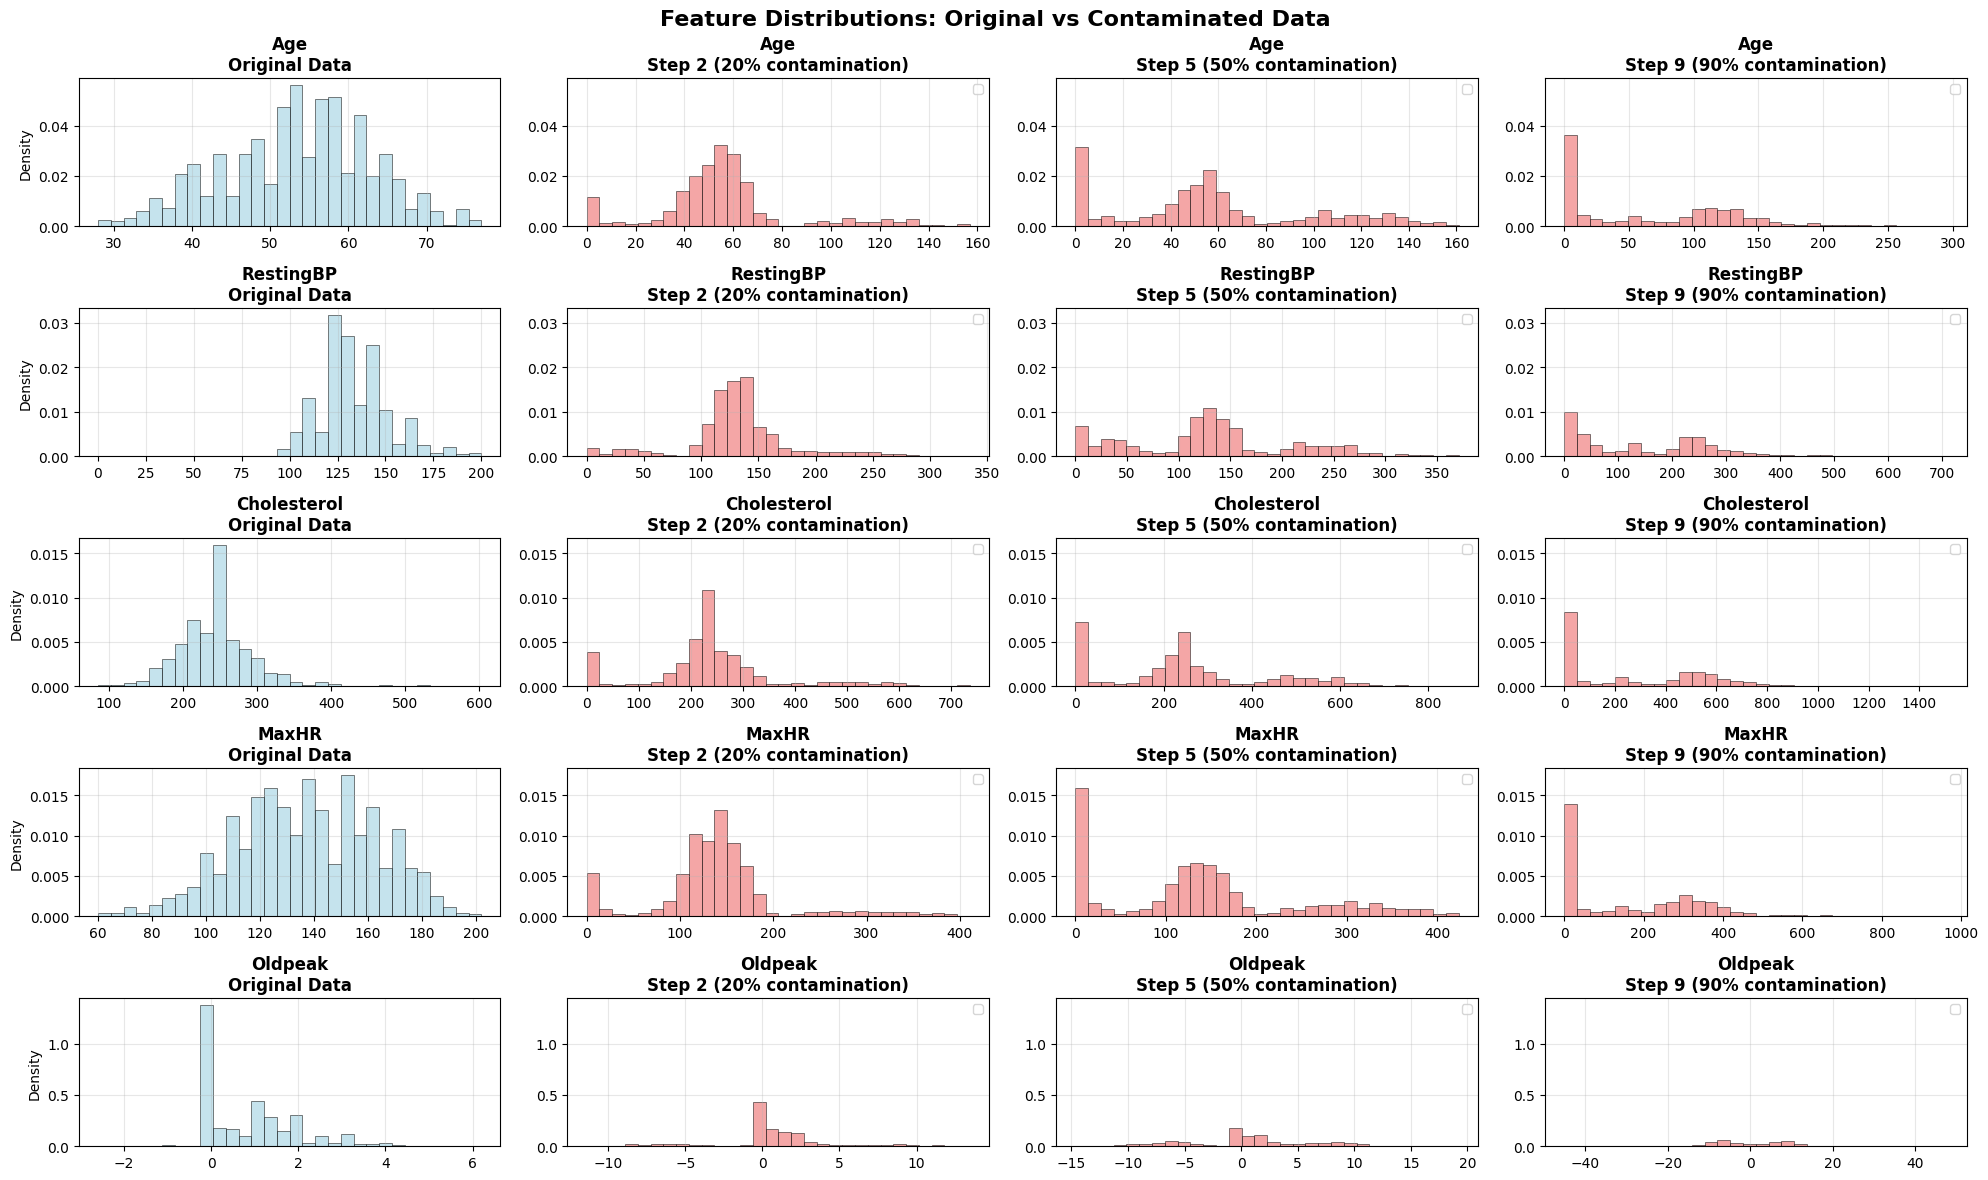

In [ ]:
def plot_feature_distributions_at_steps(generator, datasets, steps_to_show=[2, 5], figsize=(20, 12)):
    """
    Plot distributions showing original data vs contaminated data at specific contamination steps.
    
    Parameters:
    -----------
    generator : ProgressiveOutlierGenerator
        Il generatore di outliers
    datasets : list
        Lista dei dataset per ogni step
    steps_to_show : list
        Lista degli step da visualizzare (es. [2, 5, 9] per 20%, 50% e 90% se hai 10 step totali)
    figsize : tuple
        Dimensione della figura
    """
    n_features = len(generator.continuous_features)
    if n_features == 0:
        print("No features to visualize")
        return
    
    # Calcola la percentuale di contaminazione per ogni step
    total_steps = len(datasets) - 1  # -1 perché il primo dataset è quello originale
    if total_steps == 0:
        print("No contamination steps available")
        return
    
    print(f"Total contamination steps: {total_steps}")
    print(f"Steps to visualize: {steps_to_show}")
    
    # Verifica che gli step richiesti esistano
    valid_steps = [step for step in steps_to_show if step < len(datasets)]
    if not valid_steps:
        print(f"Error: Requested steps {steps_to_show} are out of range. Available steps: 0-{len(datasets)-1}")
        return
    
    # Calcola il layout della griglia
    n_datasets = len(valid_steps) + 1  # +1 per il dataset originale
    n_cols = n_datasets  # Una colonna per ogni dataset
    n_rows = n_features
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    
    # Handle single feature case
    if n_features == 1:
        axes = axes.reshape(1, -1)
    elif n_datasets == 1:
        axes = axes.reshape(-1, 1)
    
    # Colori per ogni dataset
    colors = ['lightblue', 'lightcoral', 'lightcoral', 'lightcoral', 'lightcoral']
    
    for i, feature in enumerate(generator.continuous_features):
        # Colonna 0: Dataset originale
        ax_orig = axes[i, 0] if n_features > 1 or n_datasets > 1 else axes
        original_data = generator.original_df[feature]
        
        ax_orig.hist(original_data, alpha=0.7, bins=30, color='lightblue', 
                    density=True, edgecolor='black', linewidth=0.5)
        ax_orig.set_title(f'{feature}\nOriginal Data', fontsize=12, fontweight='bold')
        ax_orig.set_ylabel('Density')
        ax_orig.grid(True, alpha=0.3)
        
        # Colonne successive: Dataset contaminati agli step specificati
        for col_idx, step in enumerate(valid_steps):
            ax = axes[i, col_idx + 1] if n_features > 1 or n_datasets > 1 else axes
            
            # Dati contaminati per questo step
            contaminated_data = datasets[step][feature]
            
            # Percentuale di contaminazione per questo step
            contamination_rate = (step / total_steps) * 100 if total_steps > 0 else 0
            
            # Plot istogramma
            ax.hist(contaminated_data, alpha=0.7, bins=30, 
                   color=colors[col_idx + 1], density=True, 
                   edgecolor='black', linewidth=0.5)
            
            # Trova gli outliers per questo step e questa feature
            outliers_for_step = []
            
            # Raccoglie tutti gli outliers fino a questo step
            for hist_idx in range(min(step + 1, len(generator.contamination_history))):
                history = generator.contamination_history[hist_idx]
                if feature in history['continuous_info']:
                    for outlier_info in history['continuous_info'][feature]:
                        outliers_for_step.append(outlier_info['outlier_value'])
                
            ax.set_title(f'{feature}\nStep {step} ({contamination_rate:.0f}% contamination)', 
                        fontsize=12, fontweight='bold')
            ax.grid(True, alpha=0.3)
            
            if outliers_for_step:
                ax.legend(fontsize=9)
        
        # Imposta la stessa scala Y per tutti i grafici di questa feature
        y_limits = []
        for col_idx in range(n_datasets):
            ax = axes[i, col_idx] if n_features > 1 or n_datasets > 1 else axes
            y_limits.extend(ax.get_ylim())
        
        y_min, y_max = min(y_limits), max(y_limits)
        for col_idx in range(n_datasets):
            ax = axes[i, col_idx] if n_features > 1 or n_datasets > 1 else axes
            ax.set_ylim(y_min, y_max)

    plt.suptitle(f'Feature Distributions: Original vs Contaminated Data',
                fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

# Usage examples:
print("Generating visualizations at specific contamination steps...")

# Mostra le distribuzioni al 20% e 50% e 90%
plot_feature_distributions_at_steps(generator, datasets, steps_to_show=[2, 5, 9])

In [20]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import recall_score, f1_score, precision_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np
import time
from sklearn.inspection import permutation_importance


In [21]:
all_metrics_outliers = []

def calculate_metrics(y_test, y_pred, model_name, approach, step_idx):
    """
    Calculate metrics and return a dictionary with model info
    """
    metrics = {
        'model': model_name,
        'approach': approach,
        'step': step_idx,
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1_score': f1_score(y_test, y_pred)
    }
    
    # Print metrics (to maintain your current output format)
    print(f"Misure di performance globali {model_name.lower()} {approach.lower()}\n")
    print('Accuracy:', metrics['accuracy'])
    print('Precision:', metrics['precision'])
    print('Recall:', metrics['recall'])
    print('F1-score:', metrics['f1_score'])
    
    return metrics

timing_collector_outliers = {
    'dt_naive_training': 0,
    'dt_optimal_training': 0, 
    'dt_hyperparameter': 0,
    'svm_naive_training': 0,
    'svm_optimal_training': 0,
    'svm_hyperparameter': 0,
    'nn_naive_training': 0,
    'nn_optimal_training': 0,
    'nn_hyperparameter': 0
}



DECISION TREE - NAIVE


===== Training Decision Tree (Naive) at Step 0 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Step 0 | Training time (Naive): 0.0049 sec
Step 0 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.7554347826086957
Precision: 0.8369565217391305
Recall: 0.719626168224299
F1-score: 0.7738693467336684


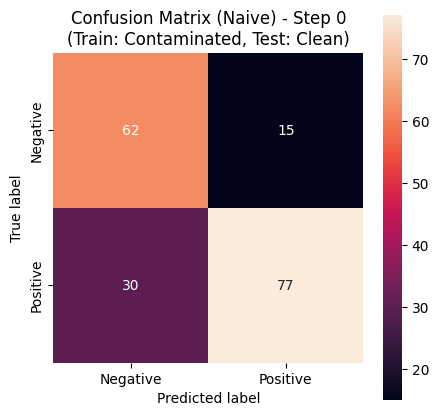

[0.04326565 0.02248514 0.0519099  0.06874242 0.01503973 0.12158308
 0.01236147 0.11282642 0.07745198 0.         0.00732902 0.00710693
 0.01419999 0.0092911  0.01368098 0.         0.         0.42272619]

===== Training Decision Tree (Naive) at Step 1 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 1 | Training time (Naive): 0.0047 sec
Step 1 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.782608695652174
Precision: 0.8252427184466019
Recall: 0.794392523364486
F1-score: 0.8095238095238095


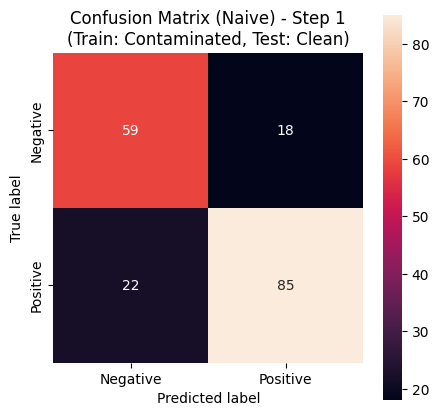

[0.05600748 0.03389793 0.06752498 0.06192796 0.02156026 0.06709299
 0.0240358  0.10472826 0.08898086 0.00561128 0.         0.00659612
 0.01400256 0.00476387 0.00408481 0.00892973 0.00752891 0.42272619]

===== Training Decision Tree (Naive) at Step 2 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 2 | Training time (Naive): 0.0027 sec
Step 2 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.7934782608695652
Precision: 0.8484848484848485
Recall: 0.7850467289719626
F1-score: 0.8155339805825242


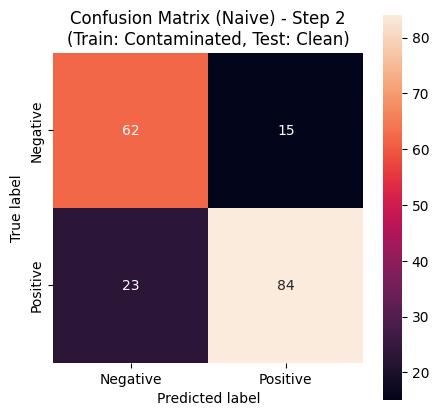

[0.06360003 0.03143301 0.06078988 0.07080225 0.02050162 0.09443427
 0.03276144 0.08652138 0.08898086 0.         0.         0.00934451
 0.00892565 0.00366451 0.00551439 0.         0.         0.42272619]

===== Training Decision Tree (Naive) at Step 3 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 3 | Training time (Naive): 0.0024 sec
Step 3 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.7934782608695652
Precision: 0.8631578947368421
Recall: 0.7663551401869159
F1-score: 0.8118811881188119


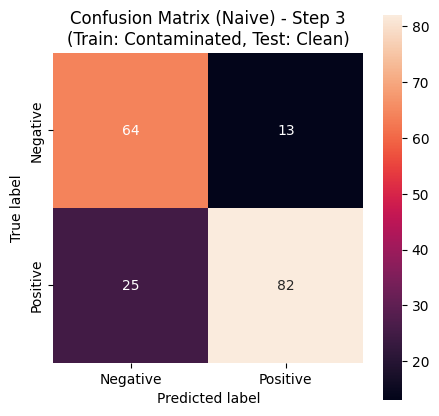

[5.23314250e-02 3.41433472e-02 4.92489603e-02 8.47233252e-02
 2.12797172e-02 8.64483127e-02 3.37289327e-02 9.32756039e-02
 8.89808608e-02 6.41289669e-03 0.00000000e+00 0.00000000e+00
 1.20786942e-02 2.46283787e-03 4.77723810e-03 7.14579917e-03
 2.35854255e-04 4.22726195e-01]

===== Training Decision Tree (Naive) at Step 4 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 4 | Training time (Naive): 0.0025 sec
Step 4 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.782608695652174
Precision: 0.8316831683168316
Recall: 0.7850467289719626
F1-score: 0.8076923076923077


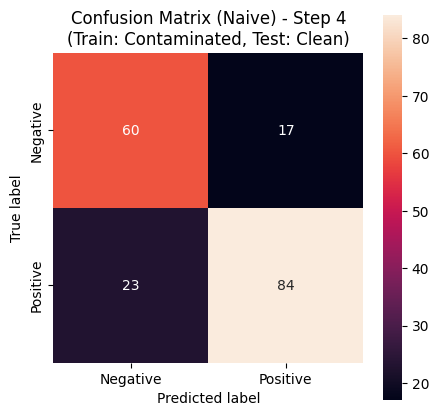

[0.07548563 0.03499285 0.06480079 0.07317988 0.02959085 0.06314901
 0.03062895 0.08378987 0.08898086 0.00824515 0.         0.00607698
 0.01000214 0.00366451 0.00141444 0.         0.00327189 0.42272619]

===== Training Decision Tree (Naive) at Step 5 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 5 | Training time (Naive): 0.0026 sec
Step 5 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.8260869565217391
Precision: 0.8640776699029126
Recall: 0.8317757009345794
F1-score: 0.8476190476190476


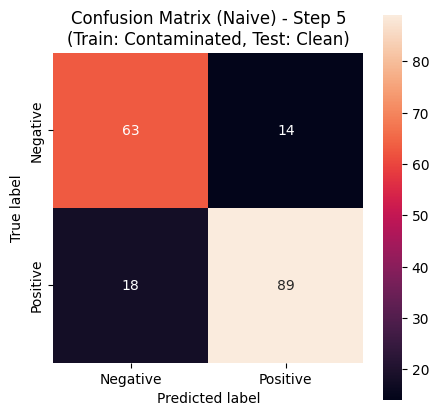

[0.05548794 0.04401136 0.07324456 0.04520668 0.02516463 0.07954207
 0.04079166 0.07861338 0.08898086 0.0085043  0.00366451 0.01299895
 0.01481844 0.00366451 0.00128429 0.00129567 0.         0.42272619]

===== Training Decision Tree (Naive) at Step 6 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 6 | Training time (Naive): 0.0025 sec
Step 6 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.8097826086956522
Precision: 0.86
Recall: 0.8037383177570093
F1-score: 0.8309178743961353


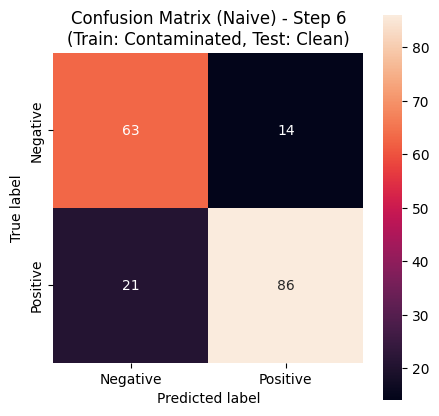

[5.87099995e-02 3.24943166e-02 8.52203314e-02 5.76778530e-02
 2.05016235e-02 6.56520482e-02 3.53957890e-02 8.03710873e-02
 8.89808608e-02 4.06352321e-04 7.14579917e-03 1.35308137e-02
 1.84264737e-02 9.00859297e-03 2.74838429e-03 0.00000000e+00
 1.00347983e-03 4.22726195e-01]

===== Training Decision Tree (Naive) at Step 7 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 7 | Training time (Naive): 0.0028 sec
Step 7 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.842391304347826
Precision: 0.8362068965517241
Recall: 0.9065420560747663
F1-score: 0.8699551569506726


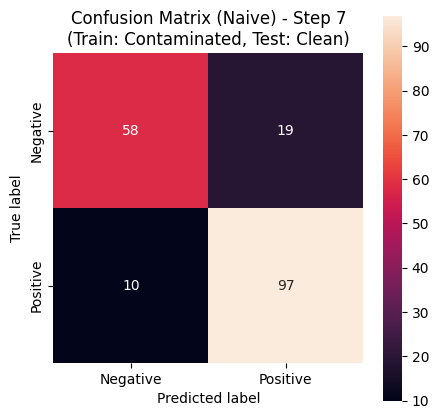

[4.28541366e-02 3.24943166e-02 9.23169811e-02 5.03338984e-02
 3.13713989e-02 7.51571857e-02 3.36551456e-02 9.53462302e-02
 8.89808608e-02 0.00000000e+00 4.12257644e-03 4.30071246e-04
 1.12807126e-02 2.74838429e-03 8.24515288e-03 7.58350481e-03
 3.53249004e-04 4.22726195e-01]

===== Training Decision Tree (Naive) at Step 8 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 8 | Training time (Naive): 0.0027 sec
Step 8 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.8206521739130435
Precision: 0.8189655172413793
Recall: 0.8878504672897196
F1-score: 0.852017937219731


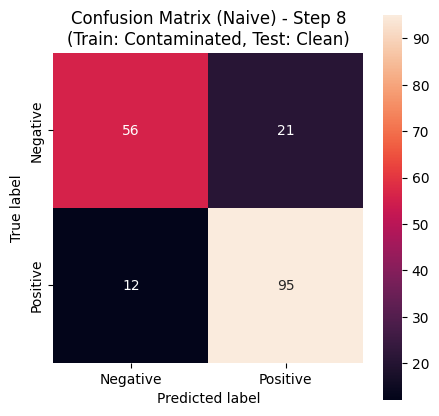

[0.05182426 0.03812581 0.09439809 0.07462082 0.03644362 0.04053251
 0.02953257 0.08382453 0.08898086 0.         0.00196313 0.00317485
 0.01384572 0.         0.00995854 0.00401776 0.00603074 0.42272619]

===== Training Decision Tree (Naive) at Step 9 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 9 | Training time (Naive): 0.0027 sec
Step 9 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.7717391304347826
Precision: 0.768595041322314
Recall: 0.8691588785046729
F1-score: 0.8157894736842105


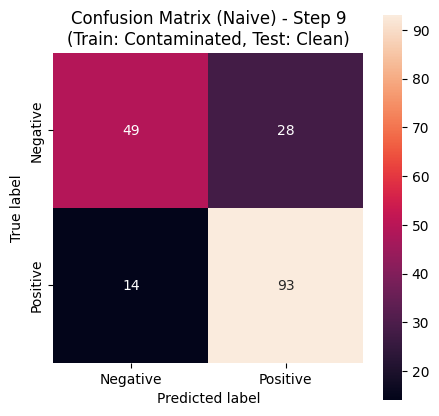

[0.06216138 0.03249432 0.07172503 0.06485233 0.02751946 0.05797889
 0.03610404 0.09449131 0.08898086 0.00545314 0.         0.00195222
 0.0118666  0.0064129  0.00778114 0.00586861 0.00163159 0.42272619]

===== Training Decision Tree (Naive) at Step 10 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 10 | Training time (Naive): 0.0027 sec
Step 10 | Training Accuracy (Naive): 1.0000
Misure di performance globali decision tree naive

Accuracy: 0.8152173913043478
Precision: 0.811965811965812
Recall: 0.8878504672897196
F1-score: 0.8482142857142857


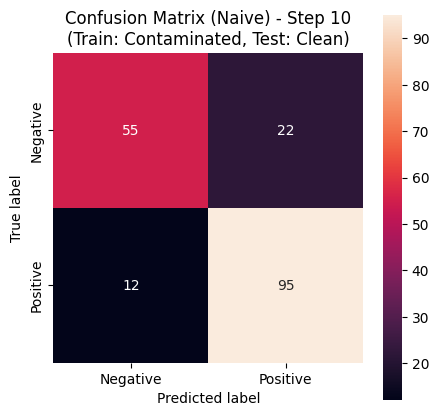

[0.04513264 0.03661689 0.07773309 0.09649691 0.01869845 0.03753933
 0.02948362 0.10729371 0.08898086 0.00366451 0.00439741 0.
 0.01761328 0.00907786 0.00077601 0.         0.00376921 0.42272619]


DECISION TREE - OPTIMIZED


===== Training Decision Tree (Optimized) at Step 0 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Step 0 | Training time (Optimized): 0.0013 sec
Step 0 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


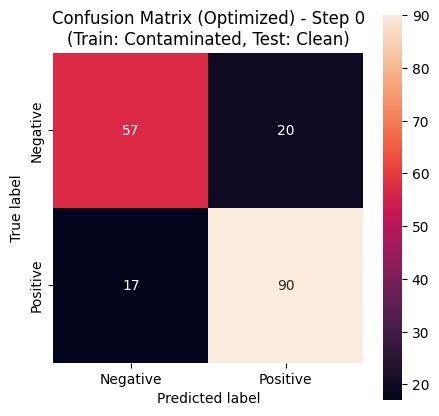

[0.         0.05681672 0.         0.         0.         0.
 0.0420269  0.00643019 0.15558415 0.         0.         0.
 0.         0.         0.         0.         0.         0.73914205]

===== Training Decision Tree (Optimized) at Step 1 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 1 | Training time (Optimized): 0.0013 sec
Step 1 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


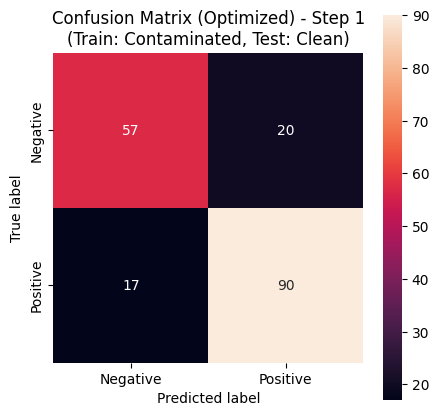

[0.         0.05696494 0.         0.         0.         0.
 0.04213654 0.00383819 0.15599003 0.         0.         0.
 0.         0.         0.         0.         0.         0.7410703 ]

===== Training Decision Tree (Optimized) at Step 2 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 2 | Training time (Optimized): 0.0025 sec
Step 2 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


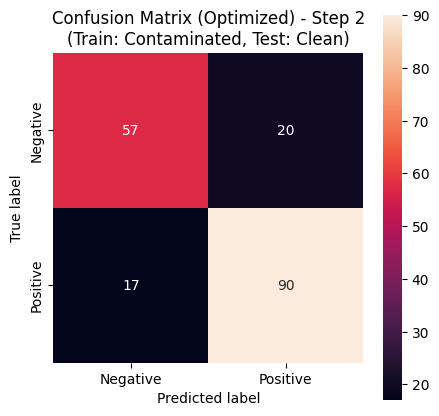

[0.         0.05655537 0.         0.         0.         0.
 0.04183358 0.01100057 0.15486847 0.         0.         0.
 0.         0.         0.         0.         0.         0.73574202]

===== Training Decision Tree (Optimized) at Step 3 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 3 | Training time (Optimized): 0.0013 sec
Step 3 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


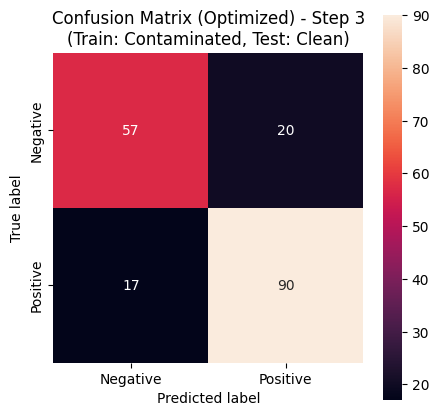

[0.         0.05647371 0.         0.         0.         0.
 0.04177318 0.01242848 0.15464487 0.         0.         0.
 0.         0.         0.         0.         0.         0.73467976]

===== Training Decision Tree (Optimized) at Step 4 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 4 | Training time (Optimized): 0.0012 sec
Step 4 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


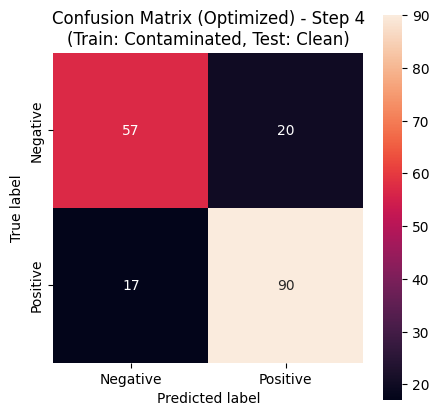

[0.         0.05699959 0.         0.         0.         0.
 0.04216216 0.         0.1560849  0.         0.         0.00323235
 0.         0.         0.         0.         0.         0.741521  ]

===== Training Decision Tree (Optimized) at Step 5 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 5 | Training time (Optimized): 0.0025 sec
Step 5 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


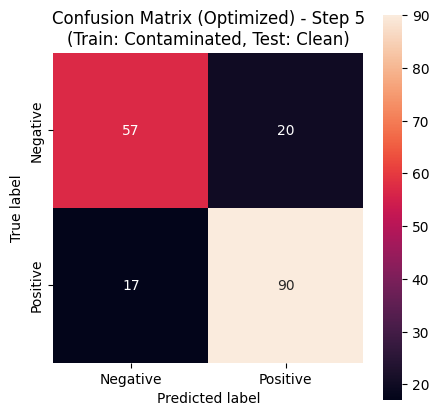

[0.         0.05699959 0.         0.         0.         0.
 0.04216216 0.         0.1560849  0.         0.         0.00323235
 0.         0.         0.         0.         0.         0.741521  ]

===== Training Decision Tree (Optimized) at Step 6 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 6 | Training time (Optimized): 0.0025 sec
Step 6 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


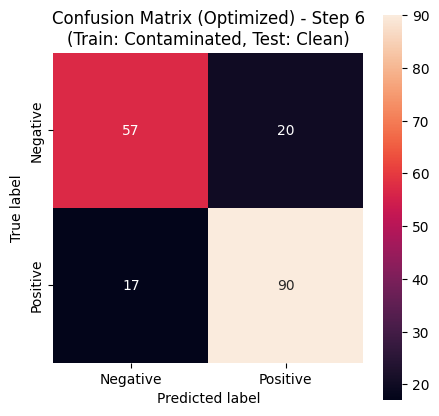

[0.         0.05699959 0.         0.         0.         0.
 0.04216216 0.         0.1560849  0.         0.         0.00323235
 0.         0.         0.         0.         0.         0.741521  ]

===== Training Decision Tree (Optimized) at Step 7 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 7 | Training time (Optimized): 0.0013 sec
Step 7 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


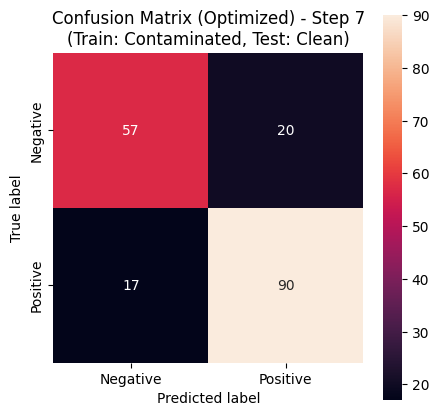

[0.         0.05699959 0.         0.         0.         0.
 0.04216216 0.         0.1560849  0.         0.         0.00323235
 0.         0.         0.         0.         0.         0.741521  ]

===== Training Decision Tree (Optimized) at Step 8 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 8 | Training time (Optimized): 0.0011 sec
Step 8 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


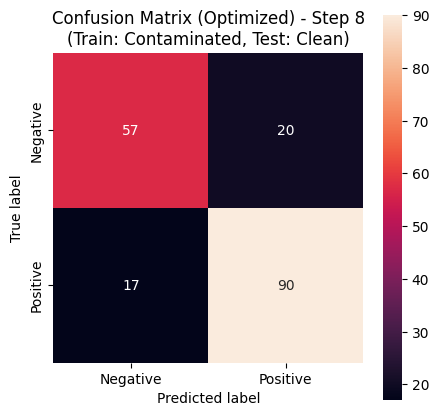

[0.         0.05691539 0.         0.         0.         0.
 0.04209988 0.00470472 0.15585434 0.         0.         0.
 0.         0.         0.         0.         0.         0.74042566]

===== Training Decision Tree (Optimized) at Step 9 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 9 | Training time (Optimized): 0.0014 sec
Step 9 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


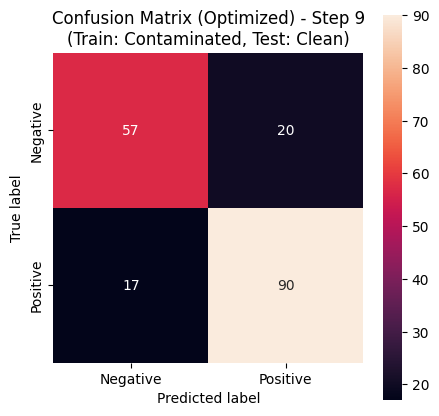

[0.         0.05699959 0.         0.         0.         0.
 0.04216216 0.         0.1560849  0.         0.         0.00323235
 0.         0.         0.         0.         0.         0.741521  ]

===== Training Decision Tree (Optimized) at Step 10 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 10 | Training time (Optimized): 0.0022 sec
Step 10 | Training Accuracy (Optimized): 0.8651
Misure di performance globali decision tree optimized

Accuracy: 0.7989130434782609
Precision: 0.8181818181818182
Recall: 0.8411214953271028
F1-score: 0.8294930875576036


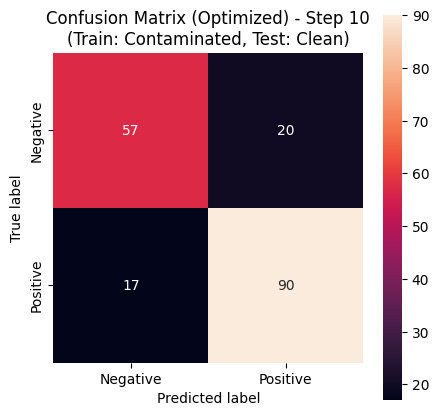

[0.         0.05699959 0.         0.         0.         0.
 0.04216216 0.         0.1560849  0.         0.         0.00323235
 0.         0.         0.         0.         0.         0.741521  ]


SVM - NAIVE


===== Training SVM (Naive) at Step 0 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Step 0 | Training time (Naive): 0.0150 sec
Step 0 | Training Accuracy (Naive): 0.7044
Misure di performance globali svm naive

Accuracy: 0.6739130434782609
Precision: 0.7238095238095238
Recall: 0.7102803738317757
F1-score: 0.7169811320754716


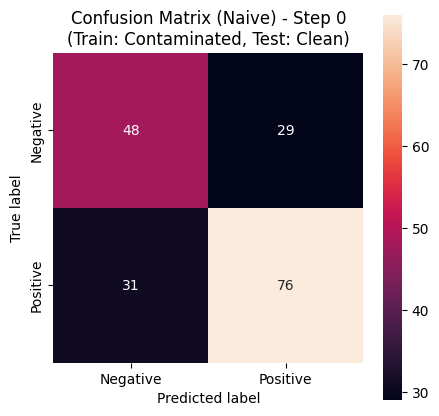


===== Training SVM (Naive) at Step 1 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 1 | Training time (Naive): 0.0205 sec
Step 1 | Training Accuracy (Naive): 0.6417
Misure di performance globali svm naive

Accuracy: 0.7065217391304348
Precision: 0.6879432624113475
Recall: 0.9065420560747663
F1-score: 0.782258064516129


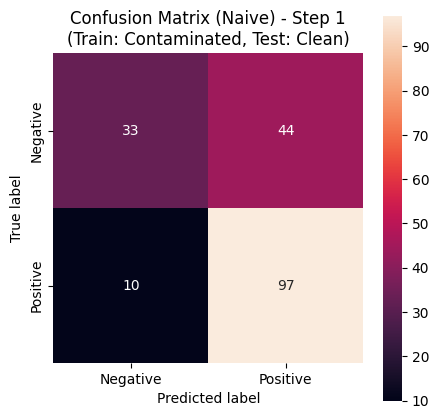


===== Training SVM (Naive) at Step 2 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 2 | Training time (Naive): 0.0110 sec
Step 2 | Training Accuracy (Naive): 0.5831
Misure di performance globali svm naive

Accuracy: 0.592391304347826
Precision: 0.5879120879120879
Recall: 1.0
F1-score: 0.740484429065744


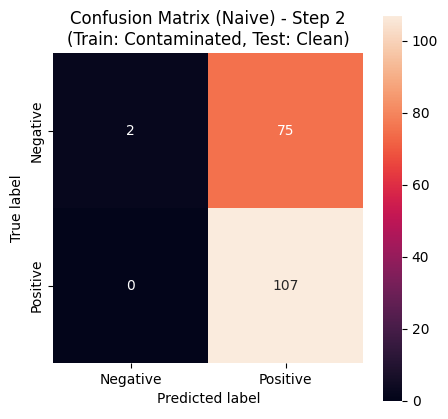


===== Training SVM (Naive) at Step 3 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 3 | Training time (Naive): 0.0119 sec
Step 3 | Training Accuracy (Naive): 0.5681
Misure di performance globali svm naive

Accuracy: 0.5815217391304348
Precision: 0.5815217391304348
Recall: 1.0
F1-score: 0.7353951890034365


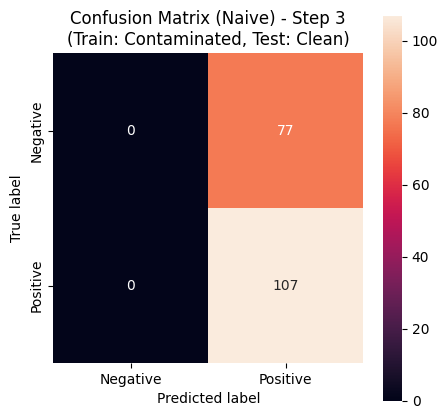


===== Training SVM (Naive) at Step 4 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 4 | Training time (Naive): 0.0098 sec
Step 4 | Training Accuracy (Naive): 0.5722
Misure di performance globali svm naive

Accuracy: 0.5815217391304348
Precision: 0.5815217391304348
Recall: 1.0
F1-score: 0.7353951890034365


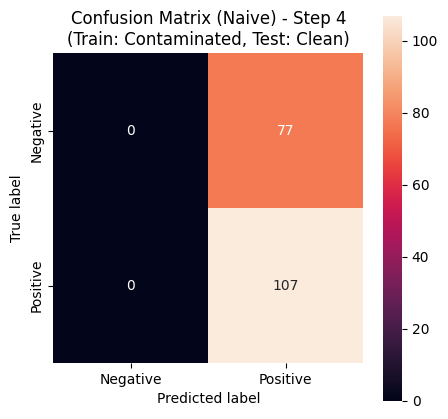


===== Training SVM (Naive) at Step 5 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 5 | Training time (Naive): 0.0096 sec
Step 5 | Training Accuracy (Naive): 0.5599
Misure di performance globali svm naive

Accuracy: 0.5815217391304348
Precision: 0.5815217391304348
Recall: 1.0
F1-score: 0.7353951890034365


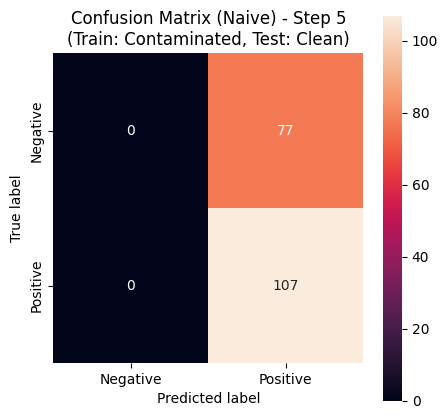


===== Training SVM (Naive) at Step 6 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 6 | Training time (Naive): 0.0096 sec
Step 6 | Training Accuracy (Naive): 0.5627
Misure di performance globali svm naive

Accuracy: 0.5815217391304348
Precision: 0.5815217391304348
Recall: 1.0
F1-score: 0.7353951890034365


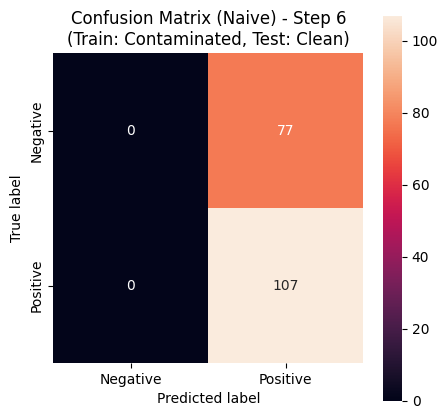


===== Training SVM (Naive) at Step 7 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 7 | Training time (Naive): 0.0110 sec
Step 7 | Training Accuracy (Naive): 0.5463
Misure di performance globali svm naive

Accuracy: 0.5815217391304348
Precision: 0.5815217391304348
Recall: 1.0
F1-score: 0.7353951890034365


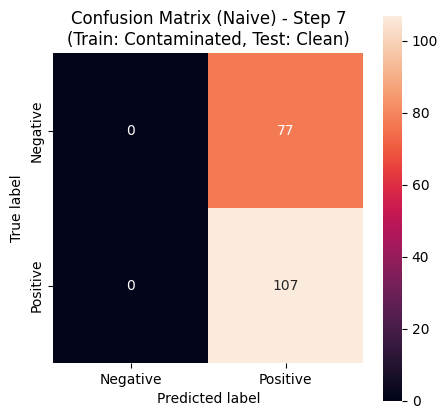


===== Training SVM (Naive) at Step 8 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 8 | Training time (Naive): 0.0093 sec
Step 8 | Training Accuracy (Naive): 0.5640
Misure di performance globali svm naive

Accuracy: 0.5815217391304348
Precision: 0.5815217391304348
Recall: 1.0
F1-score: 0.7353951890034365


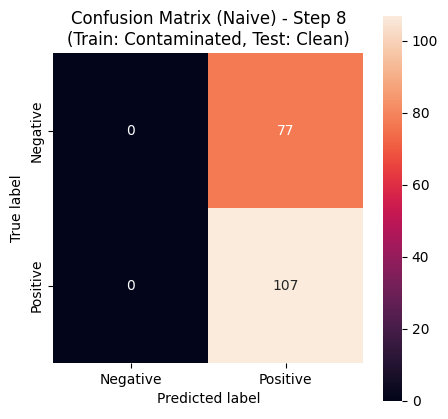


===== Training SVM (Naive) at Step 9 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 9 | Training time (Naive): 0.0097 sec
Step 9 | Training Accuracy (Naive): 0.5572
Misure di performance globali svm naive

Accuracy: 0.5815217391304348
Precision: 0.5815217391304348
Recall: 1.0
F1-score: 0.7353951890034365


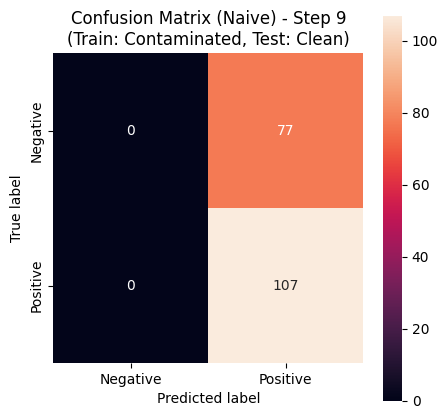


===== Training SVM (Naive) at Step 10 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 10 | Training time (Naive): 0.0096 sec
Step 10 | Training Accuracy (Naive): 0.5627
Misure di performance globali svm naive

Accuracy: 0.5815217391304348
Precision: 0.5815217391304348
Recall: 1.0
F1-score: 0.7353951890034365


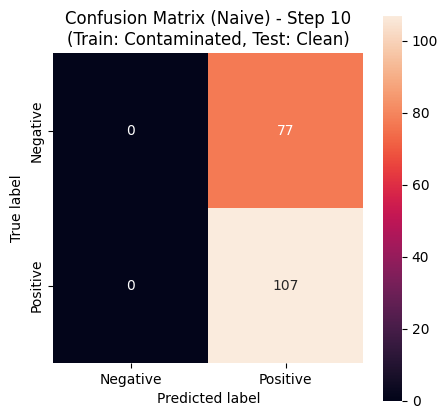



SVM - OPTIMIZED


===== Training SVM (Optimized) at Step 0 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Step 0 | Training time (Optimized): 0.0127 sec
Step 0 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.6141304347826086
Precision: 0.652542372881356
Recall: 0.719626168224299
F1-score: 0.6844444444444444


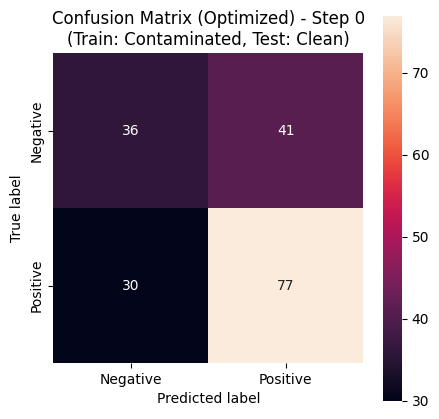


===== Training SVM (Optimized) at Step 1 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 1 | Training time (Optimized): 0.0172 sec
Step 1 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.5652173913043478
Precision: 0.6134453781512605
Recall: 0.6822429906542056
F1-score: 0.6460176991150443


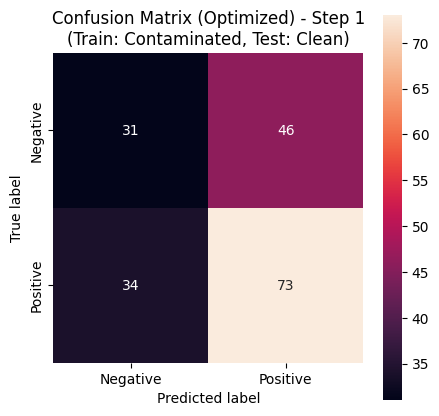


===== Training SVM (Optimized) at Step 2 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 2 | Training time (Optimized): 0.0190 sec
Step 2 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.5760869565217391
Precision: 0.616
Recall: 0.719626168224299
F1-score: 0.6637931034482759


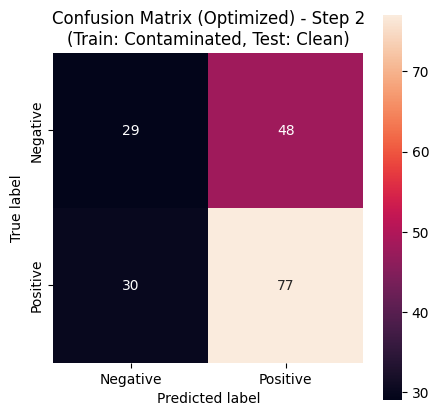


===== Training SVM (Optimized) at Step 3 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 3 | Training time (Optimized): 0.0168 sec
Step 3 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.5380434782608695
Precision: 0.5785714285714286
Recall: 0.7570093457943925
F1-score: 0.6558704453441295


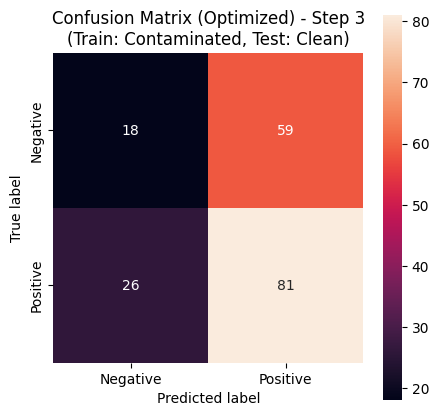


===== Training SVM (Optimized) at Step 4 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 4 | Training time (Optimized): 0.0234 sec
Step 4 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.5108695652173914
Precision: 0.5578231292517006
Recall: 0.7663551401869159
F1-score: 0.6456692913385826


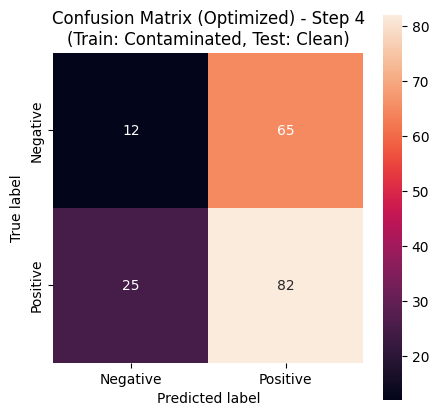


===== Training SVM (Optimized) at Step 5 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 5 | Training time (Optimized): 0.0229 sec
Step 5 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.4945652173913043
Precision: 0.5443037974683544
Recall: 0.8037383177570093
F1-score: 0.6490566037735849


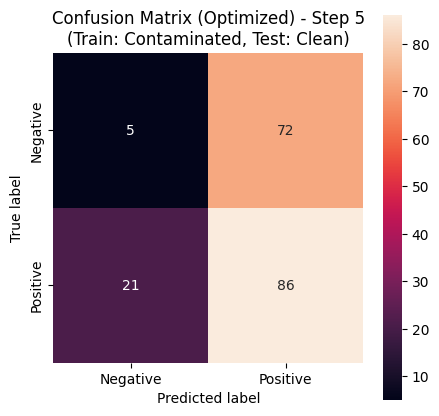


===== Training SVM (Optimized) at Step 6 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 6 | Training time (Optimized): 0.0741 sec
Step 6 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.5434782608695652
Precision: 0.5680473372781065
Recall: 0.897196261682243
F1-score: 0.6956521739130435


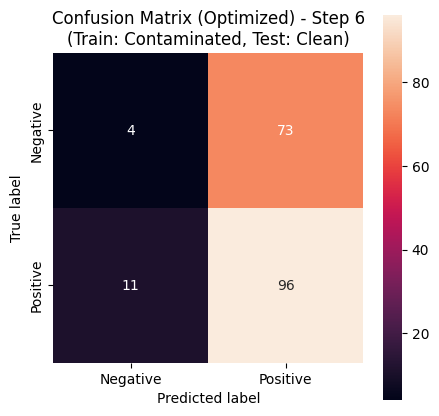


===== Training SVM (Optimized) at Step 7 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 7 | Training time (Optimized): 0.0173 sec
Step 7 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.5760869565217391
Precision: 0.5792349726775956
Recall: 0.9906542056074766
F1-score: 0.7310344827586207


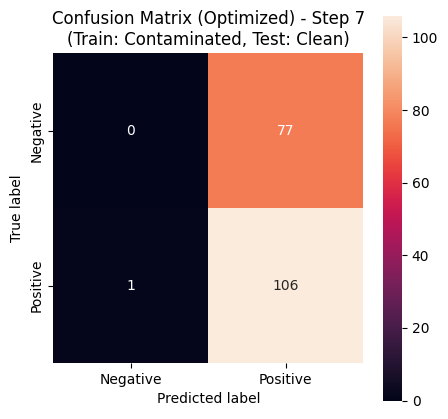


===== Training SVM (Optimized) at Step 8 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 8 | Training time (Optimized): 0.0180 sec
Step 8 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.5815217391304348
Precision: 0.5815217391304348
Recall: 1.0
F1-score: 0.7353951890034365


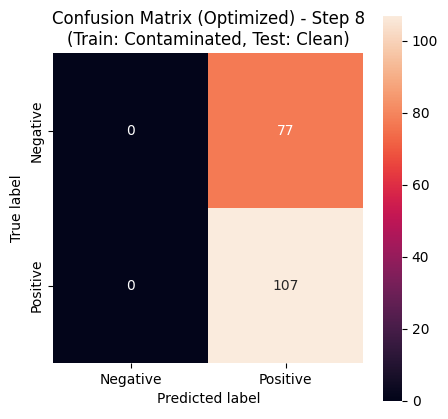


===== Training SVM (Optimized) at Step 9 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 9 | Training time (Optimized): 0.0185 sec
Step 9 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.5815217391304348
Precision: 0.5815217391304348
Recall: 1.0
F1-score: 0.7353951890034365


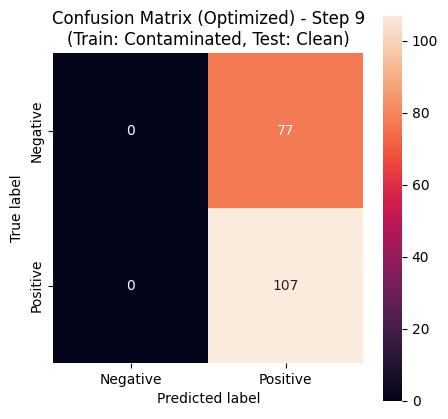


===== Training SVM (Optimized) at Step 10 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 10 | Training time (Optimized): 0.0134 sec
Step 10 | Training Accuracy (Optimized): 1.0000
Misure di performance globali svm optimized

Accuracy: 0.5815217391304348
Precision: 0.5815217391304348
Recall: 1.0
F1-score: 0.7353951890034365


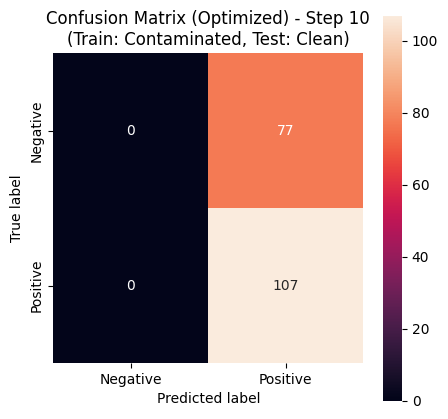



NEURAL NETWORK - NAIVE


===== Training Neural Network (Naive) at Step 0 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Step 0 | Training time (Naive): 0.1529 sec
Step 0 | Training Accuracy (Naive): 0.8747
Misure di performance globali neural network naive

Accuracy: 0.842391304347826
Precision: 0.8362068965517241
Recall: 0.9065420560747663
F1-score: 0.8699551569506726


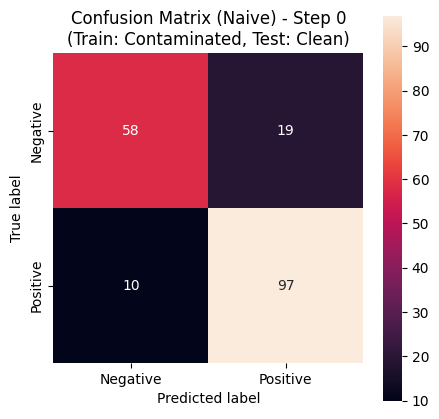


===== Training Neural Network (Naive) at Step 1 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 1 | Training time (Naive): 0.1744 sec
Step 1 | Training Accuracy (Naive): 0.9033
Misure di performance globali neural network naive

Accuracy: 0.8097826086956522
Precision: 0.8214285714285714
Recall: 0.8598130841121495
F1-score: 0.8401826484018264


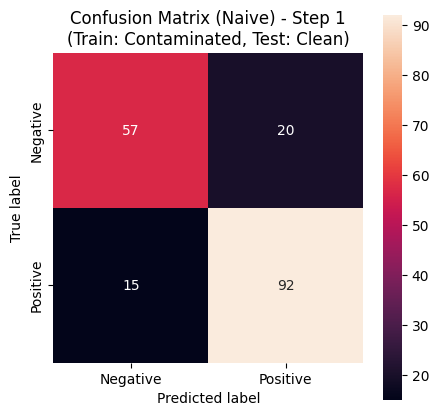


===== Training Neural Network (Naive) at Step 2 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 2 | Training time (Naive): 0.4497 sec
Step 2 | Training Accuracy (Naive): 0.9142
Misure di performance globali neural network naive

Accuracy: 0.782608695652174
Precision: 0.8130841121495327
Recall: 0.8130841121495327
F1-score: 0.8130841121495327


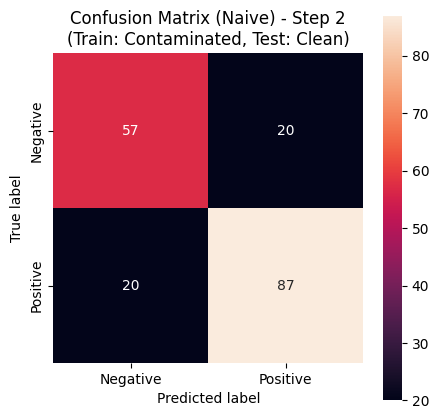


===== Training Neural Network (Naive) at Step 3 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 3 | Training time (Naive): 0.1469 sec
Step 3 | Training Accuracy (Naive): 0.8924
Misure di performance globali neural network naive

Accuracy: 0.8478260869565217
Precision: 0.8264462809917356
Recall: 0.9345794392523364
F1-score: 0.8771929824561403


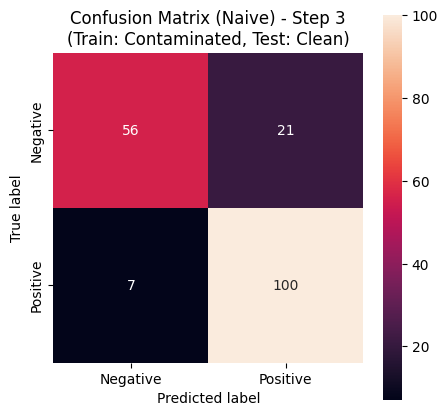


===== Training Neural Network (Naive) at Step 4 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 4 | Training time (Naive): 0.1535 sec
Step 4 | Training Accuracy (Naive): 0.8747
Misure di performance globali neural network naive

Accuracy: 0.7608695652173914
Precision: 0.8461538461538461
Recall: 0.719626168224299
F1-score: 0.7777777777777778


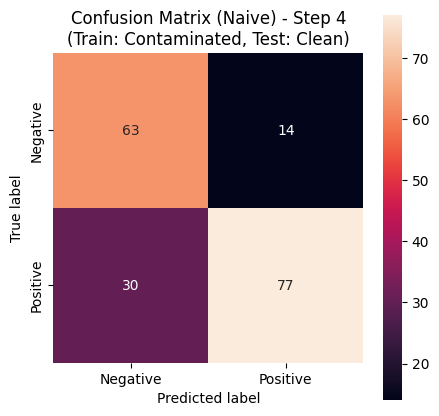


===== Training Neural Network (Naive) at Step 5 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 5 | Training time (Naive): 0.1288 sec
Step 5 | Training Accuracy (Naive): 0.8692
Misure di performance globali neural network naive

Accuracy: 0.7880434782608695
Precision: 0.8469387755102041
Recall: 0.7757009345794392
F1-score: 0.8097560975609757


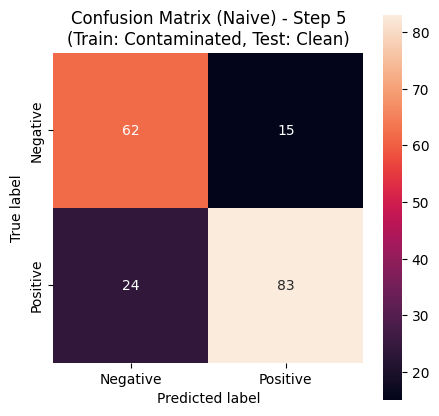


===== Training Neural Network (Naive) at Step 6 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 6 | Training time (Naive): 0.3021 sec
Step 6 | Training Accuracy (Naive): 0.9128
Misure di performance globali neural network naive

Accuracy: 0.8260869565217391
Precision: 0.8260869565217391
Recall: 0.8878504672897196
F1-score: 0.8558558558558559


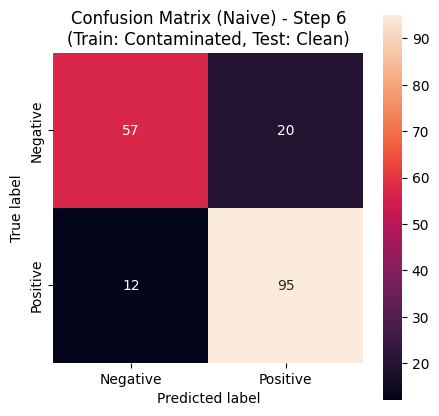


===== Training Neural Network (Naive) at Step 7 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 7 | Training time (Naive): 0.2041 sec
Step 7 | Training Accuracy (Naive): 0.8801
Misure di performance globali neural network naive

Accuracy: 0.7880434782608695
Precision: 0.8035714285714286
Recall: 0.8411214953271028
F1-score: 0.821917808219178


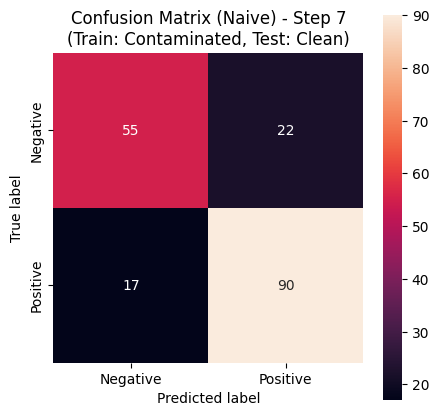


===== Training Neural Network (Naive) at Step 8 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 8 | Training time (Naive): 0.1182 sec
Step 8 | Training Accuracy (Naive): 0.8965
Misure di performance globali neural network naive

Accuracy: 0.7989130434782609
Precision: 0.7777777777777778
Recall: 0.9158878504672897
F1-score: 0.8412017167381974


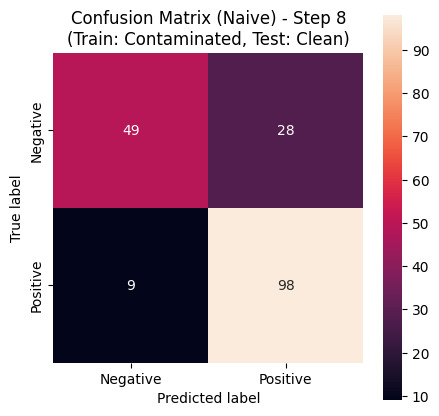


===== Training Neural Network (Naive) at Step 9 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 9 | Training time (Naive): 0.1756 sec
Step 9 | Training Accuracy (Naive): 0.8624
Misure di performance globali neural network naive

Accuracy: 0.7608695652173914
Precision: 0.7333333333333333
Recall: 0.9252336448598131
F1-score: 0.8181818181818182


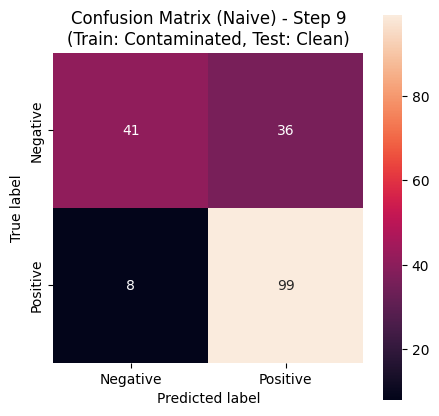


===== Training Neural Network (Naive) at Step 10 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 10 | Training time (Naive): 0.1237 sec
Step 10 | Training Accuracy (Naive): 0.8624
Misure di performance globali neural network naive

Accuracy: 0.782608695652174
Precision: 0.7768595041322314
Recall: 0.8785046728971962
F1-score: 0.8245614035087719


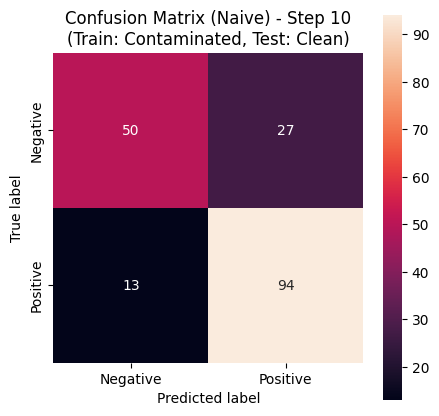



NEURAL NETWORK - OPTIMIZED


===== Training Neural Network (Optimized) at Step 0 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Step 0 | Training time (Optimized): 0.1933 sec
Step 0 | Training Accuracy (Optimized): 0.8747
Misure di performance globali neural network optimized

Accuracy: 0.842391304347826
Precision: 0.8362068965517241
Recall: 0.9065420560747663
F1-score: 0.8699551569506726


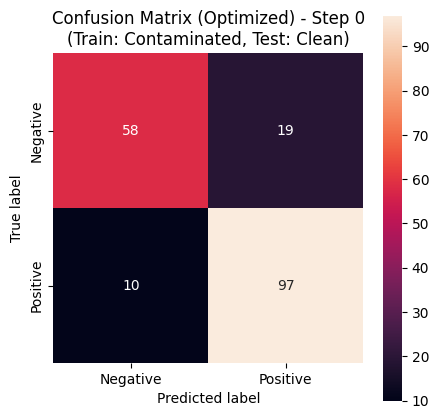


===== Training Neural Network (Optimized) at Step 1 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 1 | Training time (Optimized): 0.1164 sec
Step 1 | Training Accuracy (Optimized): 0.9033
Misure di performance globali neural network optimized

Accuracy: 0.8097826086956522
Precision: 0.8214285714285714
Recall: 0.8598130841121495
F1-score: 0.8401826484018264


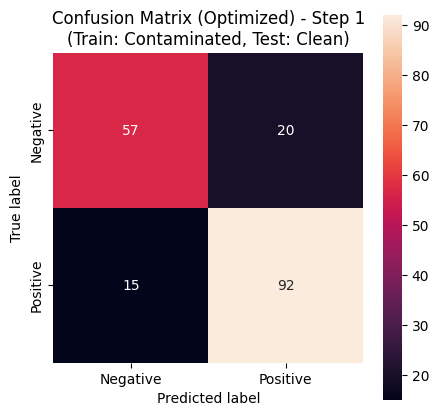


===== Training Neural Network (Optimized) at Step 2 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 2 | Training time (Optimized): 0.4101 sec
Step 2 | Training Accuracy (Optimized): 0.9142
Misure di performance globali neural network optimized

Accuracy: 0.782608695652174
Precision: 0.8130841121495327
Recall: 0.8130841121495327
F1-score: 0.8130841121495327


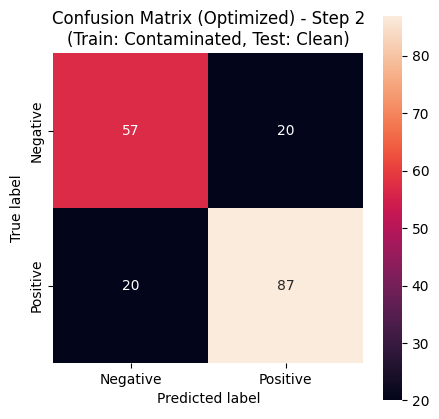


===== Training Neural Network (Optimized) at Step 3 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 3 | Training time (Optimized): 0.2089 sec
Step 3 | Training Accuracy (Optimized): 0.8924
Misure di performance globali neural network optimized

Accuracy: 0.8478260869565217
Precision: 0.8264462809917356
Recall: 0.9345794392523364
F1-score: 0.8771929824561403


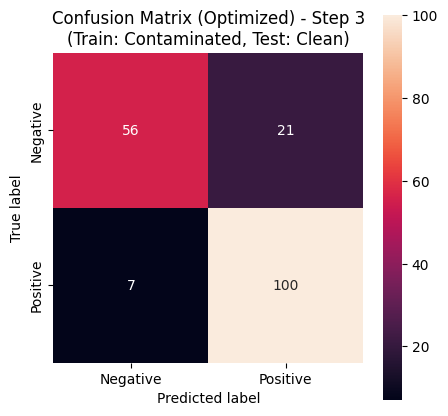


===== Training Neural Network (Optimized) at Step 4 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 4 | Training time (Optimized): 0.1208 sec
Step 4 | Training Accuracy (Optimized): 0.8747
Misure di performance globali neural network optimized

Accuracy: 0.7608695652173914
Precision: 0.8461538461538461
Recall: 0.719626168224299
F1-score: 0.7777777777777778


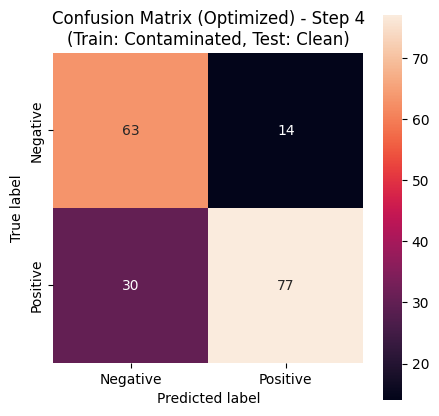


===== Training Neural Network (Optimized) at Step 5 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 5 | Training time (Optimized): 0.2080 sec
Step 5 | Training Accuracy (Optimized): 0.8692
Misure di performance globali neural network optimized

Accuracy: 0.7880434782608695
Precision: 0.8469387755102041
Recall: 0.7757009345794392
F1-score: 0.8097560975609757


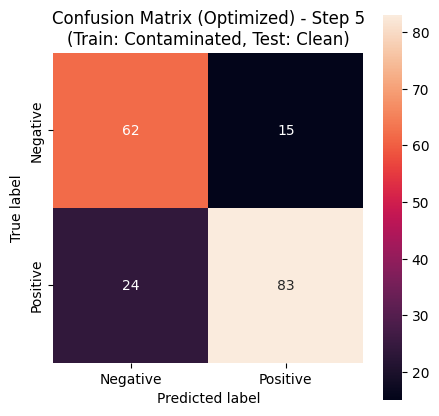


===== Training Neural Network (Optimized) at Step 6 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 6 | Training time (Optimized): 0.4374 sec
Step 6 | Training Accuracy (Optimized): 0.9128
Misure di performance globali neural network optimized

Accuracy: 0.8260869565217391
Precision: 0.8260869565217391
Recall: 0.8878504672897196
F1-score: 0.8558558558558559


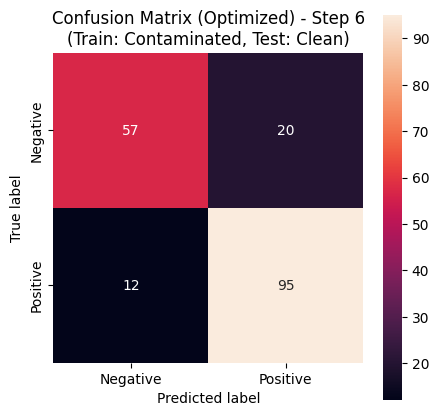


===== Training Neural Network (Optimized) at Step 7 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 7 | Training time (Optimized): 0.1123 sec
Step 7 | Training Accuracy (Optimized): 0.8801
Misure di performance globali neural network optimized

Accuracy: 0.7880434782608695
Precision: 0.8035714285714286
Recall: 0.8411214953271028
F1-score: 0.821917808219178


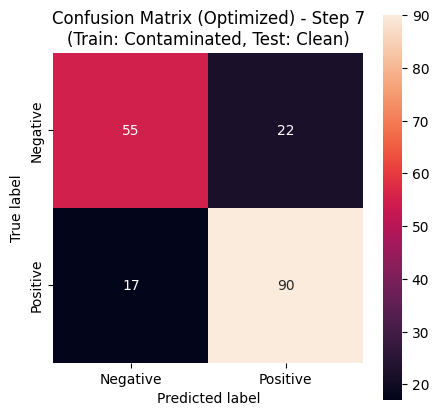


===== Training Neural Network (Optimized) at Step 8 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 8 | Training time (Optimized): 0.1577 sec
Step 8 | Training Accuracy (Optimized): 0.8965
Misure di performance globali neural network optimized

Accuracy: 0.7989130434782609
Precision: 0.7777777777777778
Recall: 0.9158878504672897
F1-score: 0.8412017167381974


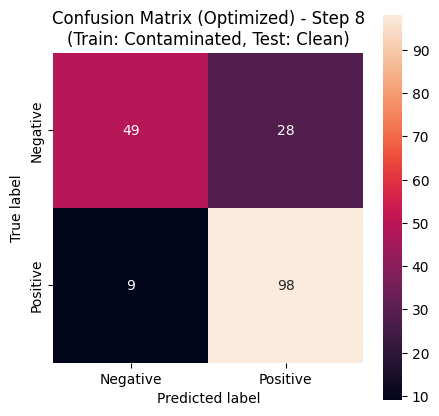


===== Training Neural Network (Optimized) at Step 9 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 9 | Training time (Optimized): 0.1282 sec
Step 9 | Training Accuracy (Optimized): 0.8624
Misure di performance globali neural network optimized

Accuracy: 0.7608695652173914
Precision: 0.7333333333333333
Recall: 0.9252336448598131
F1-score: 0.8181818181818182


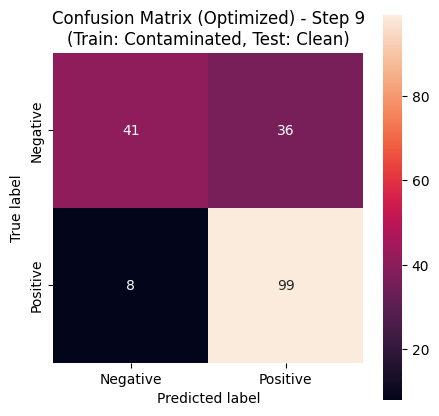


===== Training Neural Network (Optimized) at Step 10 =====
Training set size: 734 samples (contaminated)
Test set size: 184 samples (clean)
Rows with at least one contaminated value in training set: 734/734
Total contaminated values in training set: 3670/3670
Contamination rate: 1.000
Contamination by feature:
  Age: 734/734 (1.000)
  RestingBP: 734/734 (1.000)
  Cholesterol: 734/734 (1.000)
  MaxHR: 734/734 (1.000)
  Oldpeak: 734/734 (1.000)
Step 10 | Training time (Optimized): 0.1229 sec
Step 10 | Training Accuracy (Optimized): 0.8624
Misure di performance globali neural network optimized

Accuracy: 0.782608695652174
Precision: 0.7768595041322314
Recall: 0.8785046728971962
F1-score: 0.8245614035087719


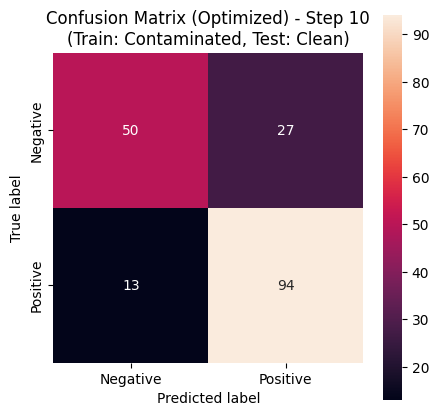

In [22]:
#import shap

best_dt = joblib.load('best_decision_tree_model.pkl')
best_svm = joblib.load('best_svm_model.pkl')
best_nn = joblib.load('best_nn_model.pkl')
best_nn_params = {
    'activation': best_nn.get('model__activation', 'relu'),
    'hidden_layer_sizes': best_nn.get('model__hidden_layer_sizes', (100,)),
    'random_state': 42,
    'max_iter': 1000
}

X_original = df.drop('HeartDisease', axis=1)  # df è il dataset originale pulito
y_original = df['HeartDisease']

# Split del dataset originale per ottenere il test set pulito
X_temp, X_test_clean, y_temp, y_test_clean = train_test_split(
    X_original, y_original, test_size=0.2, random_state=0
)

feature_importances = {}
confusion_matrix_values = {}

def count_contaminated_rows_in_training(generator, X_train_index):
    """
    Conta quante righe del training set hanno almeno un valore contaminato
    
    Parameters:
    -----------
    generator : ProgressiveOutlierGenerator
        Il generatore di outlier
    X_train_index : Index
        Gli indici delle righe nel training set
        
    Returns:
    --------
    int : Numero di righe contaminate nel training set
    """
    if not hasattr(generator, 'contaminated_values') or not generator.contaminated_values:
        return 0
    
    # Estrai solo gli indici delle righe dai valori contaminati
    contaminated_row_indices = set(row_idx for row_idx, feature in generator.contaminated_values)
    
    # Conta quante righe del training set sono contaminate
    training_contaminated_rows = len(set(X_train_index) & contaminated_row_indices)
    
    return training_contaminated_rows

def count_contaminated_values_in_training(generator, X_train_index, continuous_features):
    """
    Conta quanti valori individuali nel training set sono contaminati
    
    Parameters:
    -----------
    generator : ProgressiveOutlierGenerator
        Il generatore di outlier
    X_train_index : Index
        Gli indici delle righe nel training set
    continuous_features : list
        Lista delle feature continue
        
    Returns:
    --------
    dict : Informazioni dettagliate sulla contaminazione
    """
    if not hasattr(generator, 'contaminated_values') or not generator.contaminated_values:
        return {
            'total_contaminated_values': 0,
            'contaminated_rows': 0,
            'contamination_by_feature': {},
            'total_training_values': len(X_train_index) * len(continuous_features)
        }
    
    # Filtra i valori contaminati che sono nel training set
    training_contaminated_values = [
        (row_idx, feature) for row_idx, feature in generator.contaminated_values 
        if row_idx in X_train_index
    ]
    
    # Conta righe uniche contaminate
    contaminated_rows = len(set(row_idx for row_idx, feature in training_contaminated_values))
    
    # Conta per feature
    contamination_by_feature = {}
    for feature in continuous_features:
        feature_count = len([1 for row_idx, f in training_contaminated_values if f == feature])
        contamination_by_feature[feature] = feature_count
    
    return {
        'total_contaminated_values': len(training_contaminated_values),
        'contaminated_rows': contaminated_rows,
        'contamination_by_feature': contamination_by_feature,
        'total_training_values': len(X_train_index) * len(continuous_features)
    }

def train_and_evaluate_model(datasets, X_test_clean, y_test_clean, 
                             model_class, model_params, model_name, 
                             approach_name, timing_collector, 
                             all_metrics_list, generator=None,
                             optimized_params=None, continuous_features=None):
    """
    Funzione generica per addestrare e valutare modelli su dataset contaminati
    
    Parameters:
    -----------
    datasets : list
        Lista dei dataset contaminati per ogni step
    X_test_clean, y_test_clean : array-like
        Test set pulito (costante per tutti gli step)
    model_class : class
        Classe del modello (es. DecisionTreeClassifier, SVC, MLPClassifier)
    model_params : dict
        Parametri base del modello
    model_name : str
        Nome del modello per le metriche
    approach_name : str
        Nome dell'approccio (es. 'Naive', 'Optimized')
    timing_collector : dict
        Dizionario per raccogliere i tempi di training
    all_metrics_list : list
        Lista per raccogliere tutte le metriche
    generator : object, optional
        Generatore di outlier per contare campioni contaminati
    optimized_params : dict, optional
        Parametri ottimizzati (se diversi da model_params)
    continuous_features : list, optional
        Lista delle feature continue (per statistiche dettagliate)
    """
    
    # Usa parametri ottimizzati se forniti, altrimenti usa quelli base
    final_params = optimized_params if optimized_params is not None else model_params
    
    print(f"\n\n======================")
    print(f"{model_name.upper()} - {approach_name.upper()}")
    print(f"======================\n")

    # Crea la chiave per questo modello e approccio
    cm_key = f"{model_name} - {approach_name}"
    if cm_key not in confusion_matrix_values:
        confusion_matrix_values[cm_key] = {}
    
    for step_idx, contaminated_df in enumerate(datasets):
        print(f"\n===== Training {model_name} ({approach_name}) at Step {step_idx} =====")
        
        # Prepara dati dal dataset contaminato per il TRAINING
        X_contaminated = contaminated_df.drop('HeartDisease', axis=1)
        y_contaminated = contaminated_df['HeartDisease']
        
        # Split del dataset contaminato SOLO per ottenere il training set
        X_train_contaminated, _, y_train_contaminated, _ = train_test_split(
            X_contaminated, y_contaminated, test_size=0.2, random_state=0
        )
        
        # Training su dati contaminati, test su dati puliti
        X_train = X_train_contaminated
        y_train = y_train_contaminated
        X_test = X_test_clean
        y_test = y_test_clean
        
        print(f"Training set size: {len(X_train)} samples (contaminated)")
        print(f"Test set size: {len(X_test)} samples (clean)")
        
        # Statistiche di contaminazione dettagliate (solo se disponibile)
        if step_idx > 0 and generator is not None:
            # Conta righe contaminate nel training set
            contaminated_rows = count_contaminated_rows_in_training(generator, X_train.index)
            print(f"Rows with at least one contaminated value in training set: {contaminated_rows}/{len(X_train)}")
            
            # Se abbiamo le feature continue, mostra statistiche più dettagliate
            if continuous_features is not None:
                contamination_stats = count_contaminated_values_in_training(
                    generator, X_train.index, continuous_features
                )
                print(f"Total contaminated values in training set: {contamination_stats['total_contaminated_values']}/{contamination_stats['total_training_values']}")
                print(f"Contamination rate: {contamination_stats['total_contaminated_values']/contamination_stats['total_training_values']:.3f}")
                
                # Mostra contaminazione per feature
                print("Contamination by feature:")
                for feature, count in contamination_stats['contamination_by_feature'].items():
                    feature_total = len(X_train)
                    rate = count / feature_total if feature_total > 0 else 0
                    print(f"  {feature}: {count}/{feature_total} ({rate:.3f})")
        
        # Crea e addestra il modello
        model = model_class(**final_params)
        start_time = time.time()
        model.fit(X_train, y_train)
        end_time = time.time()
        
        training_time = end_time - start_time
        print(f"Step {step_idx} | Training time ({approach_name}): {training_time:.4f} sec")
        
        # Salva il tempo nel dizionario
        timing_key = f"{model_name.lower().replace(' ', '_')}_{approach_name.lower()}_training_step_{step_idx}"
        timing_collector[timing_key] = training_time
        
        # Accuracy sul training (contaminato)
        accuracy_train = model.score(X_train, y_train)
        print(f"Step {step_idx} | Training Accuracy ({approach_name}): {accuracy_train:.4f}")
        
        # Predizioni sul test set PULITO
        y_pred = model.predict(X_test)
        
        # Calcolo metriche
        metrics = calculate_metrics(y_test, y_pred, model_name, approach_name, step_idx)
        metrics['training_time'] = training_time
        metrics['train_accuracy'] = accuracy_train
        metrics['contamination_step'] = step_idx
        metrics['test_set_type'] = 'clean'
        
        # Aggiungi alle metriche globali
        all_metrics_list.append(metrics)
        
        # Confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        TN, FP, FN, TP = cm.ravel()
        # Salva i valori nella struttura dati
        confusion_matrix_values[cm_key][step_idx] = {
            'TN': int(TN),  # True Negative
            'FP': int(FP),  # False Positive  
            'FN': int(FN),  # False Negative
            'TP': int(TP),  # True Positive
            'confusion_matrix': cm.tolist()  # Salva anche la matrice completa
        }

        plt.figure(figsize=(5,5))
        sns.heatmap(cm, square=True, annot=True, fmt='d', cbar=True,
                   xticklabels=['Negative', 'Positive'],
                   yticklabels=['Negative', 'Positive'])
        plt.title(f"Confusion Matrix ({approach_name}) - Step {step_idx}\n(Train: Contaminated, Test: Clean)")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

        # Salvataggio feature importances per Decision Tree
        key = f"{model_name} - {approach_name}"
        if model_name == 'Decision Tree':
            print(model.feature_importances_)
            if key not in feature_importances:
                feature_importances[key] = {}
            feature_importances[key][step_idx] = model.feature_importances_
        '''
        # Salvataggio feature importances per SVM tramite SHAP
        if model_name == 'SVM':
            background = shap.sample(X_train, 20)  # Usa un piccolo campione per velocità
            explainer = shap.KernelExplainer(model.predict, background)
            shap_values = explainer.shap_values(X_train, nsamples=20)  # Limita nsamples per velocità
            mean_abs_shap = np.abs(shap_values).mean(axis=0)
            print("SHAP feature importances (SVM):", mean_abs_shap)
            if key not in feature_importances:
                feature_importances[key] = {}
            feature_importances[key][step_idx] = mean_abs_shap
        '''

# Chiamate aggiornate con continuous_features
train_and_evaluate_model(datasets=datasets,
        X_test_clean=X_test_clean,
        y_test_clean=y_test_clean,
        model_class=DecisionTreeClassifier,
        model_params={},  # Usa i parametri di default
        model_name='Decision Tree',
        approach_name='Naive',
        timing_collector=timing_collector_outliers,
        all_metrics_list=all_metrics_outliers,
        generator=generator,
        continuous_features=continuous_features)  # Aggiungi questo parametro

train_and_evaluate_model(datasets=datasets,
        X_test_clean=X_test_clean,
        y_test_clean=y_test_clean,
        model_class=DecisionTreeClassifier,
        model_params=best_dt, 
        model_name='Decision Tree',
        approach_name='Optimized',
        timing_collector=timing_collector_outliers,
        all_metrics_list=all_metrics_outliers,
        generator=generator,
        continuous_features=continuous_features)

train_and_evaluate_model(datasets=datasets,
        X_test_clean=X_test_clean,
        y_test_clean=y_test_clean,
        model_class=svm.SVC,
        model_params={},  # Usa i parametri di default
        model_name='SVM',
        approach_name='Naive',
        timing_collector=timing_collector_outliers,
        all_metrics_list=all_metrics_outliers,
        generator=generator,
        continuous_features=continuous_features)

train_and_evaluate_model(datasets=datasets,
        X_test_clean=X_test_clean,
        y_test_clean=y_test_clean,
        model_class=svm.SVC,
        model_params=best_svm, 
        model_name='SVM',
        approach_name='Optimized',
        timing_collector=timing_collector_outliers,
        all_metrics_list=all_metrics_outliers,
        generator=generator,
        continuous_features=continuous_features)

train_and_evaluate_model(datasets=datasets,
        X_test_clean=X_test_clean,
        y_test_clean=y_test_clean,
        model_class=MLPClassifier,
        model_params={'random_state': 42, 'max_iter': 1000}, 
        model_name='Neural Network',
        approach_name='Naive',
        timing_collector=timing_collector_outliers,
        all_metrics_list=all_metrics_outliers,
        generator=generator,
        continuous_features=continuous_features)

train_and_evaluate_model(datasets=datasets,
        X_test_clean=X_test_clean,
        y_test_clean=y_test_clean,
        model_class=MLPClassifier,
        model_params=best_nn_params,
        model_name='Neural Network',
        approach_name='Optimized',
        timing_collector=timing_collector_outliers,
        all_metrics_list=all_metrics_outliers,
        generator=generator,
        continuous_features=continuous_features)

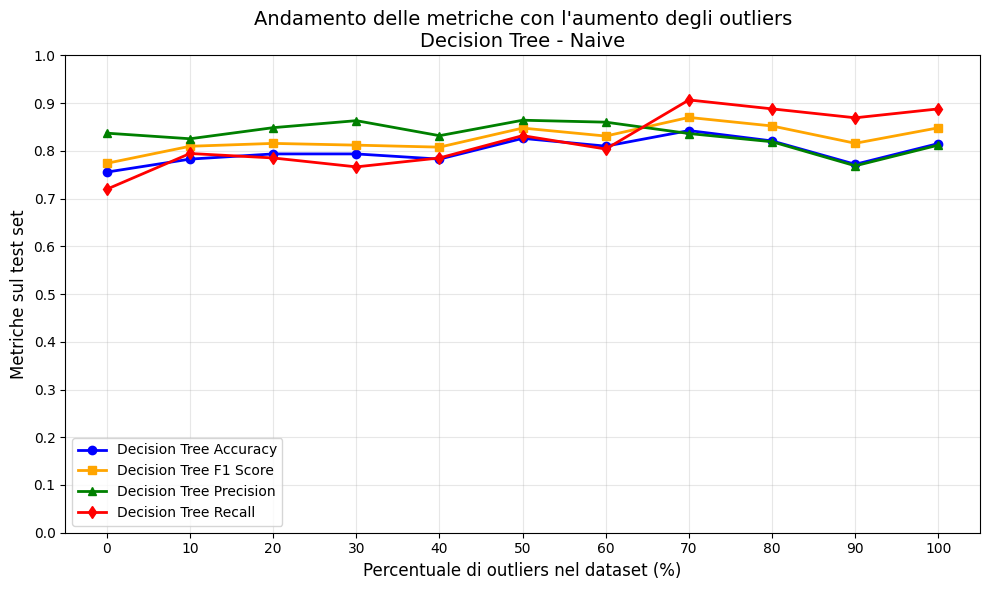

<Figure size 640x480 with 0 Axes>

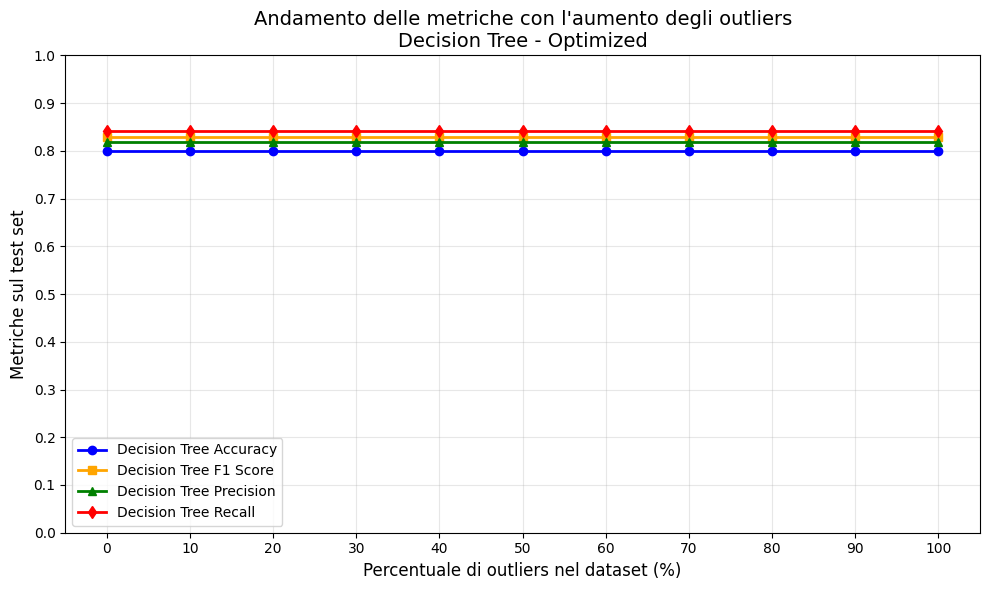

<Figure size 640x480 with 0 Axes>

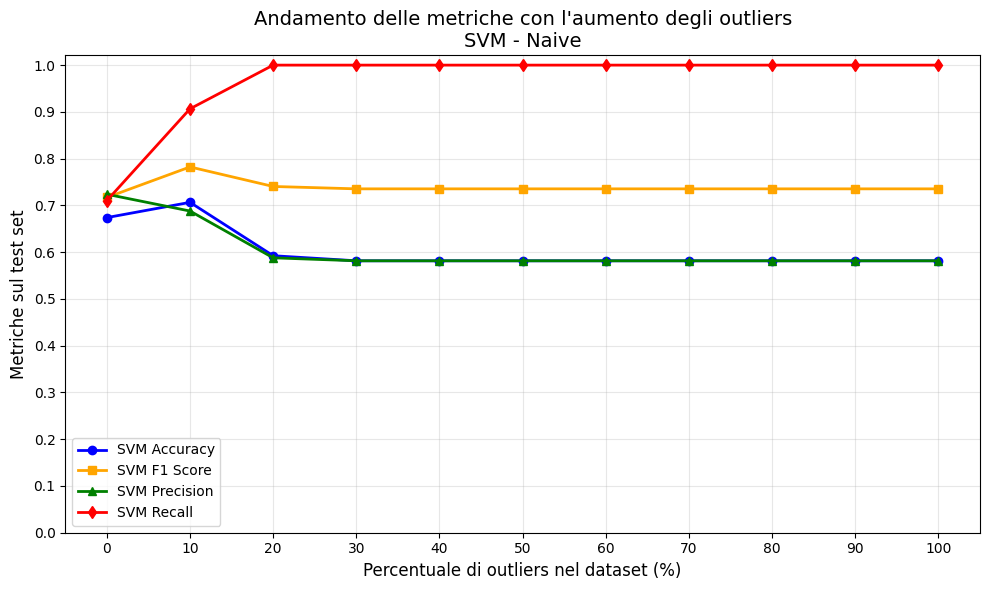

<Figure size 640x480 with 0 Axes>

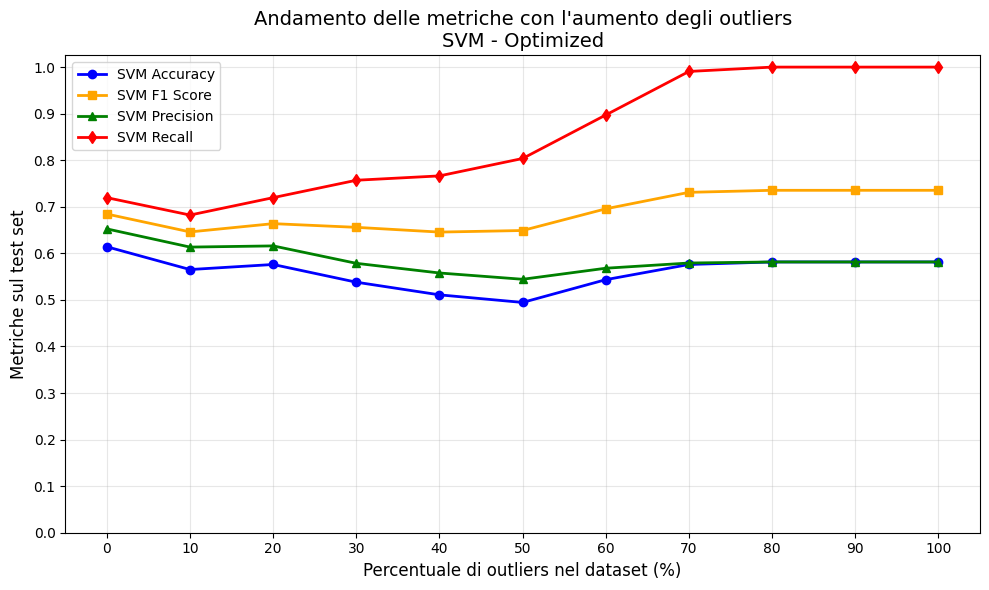

<Figure size 640x480 with 0 Axes>

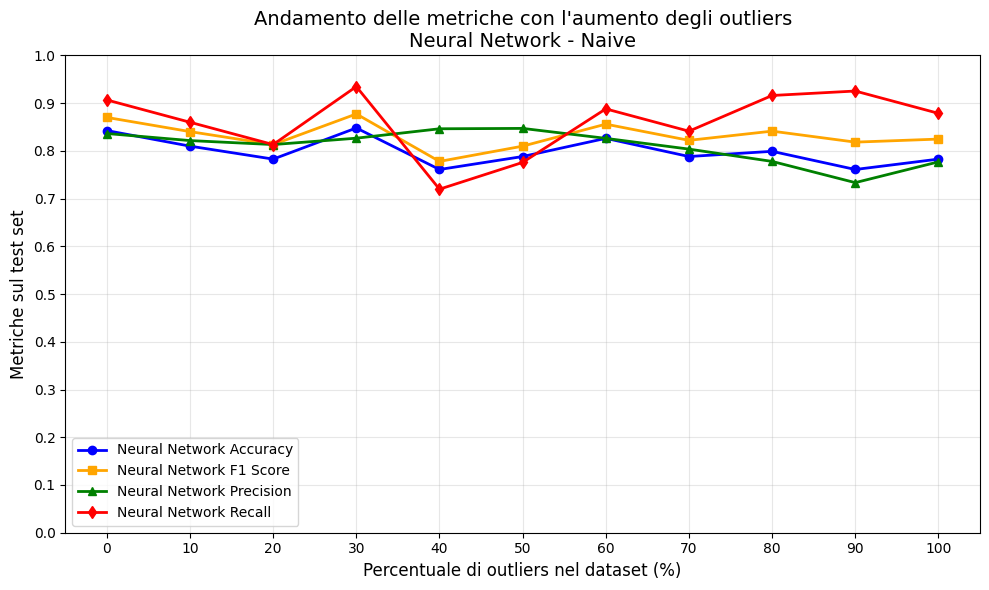

<Figure size 640x480 with 0 Axes>

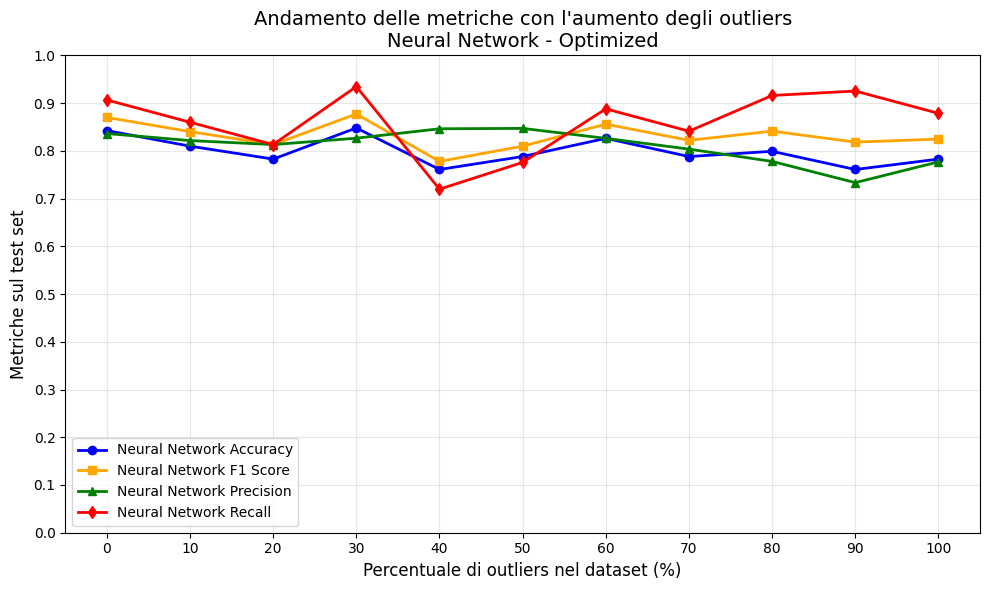

<Figure size 640x480 with 0 Axes>

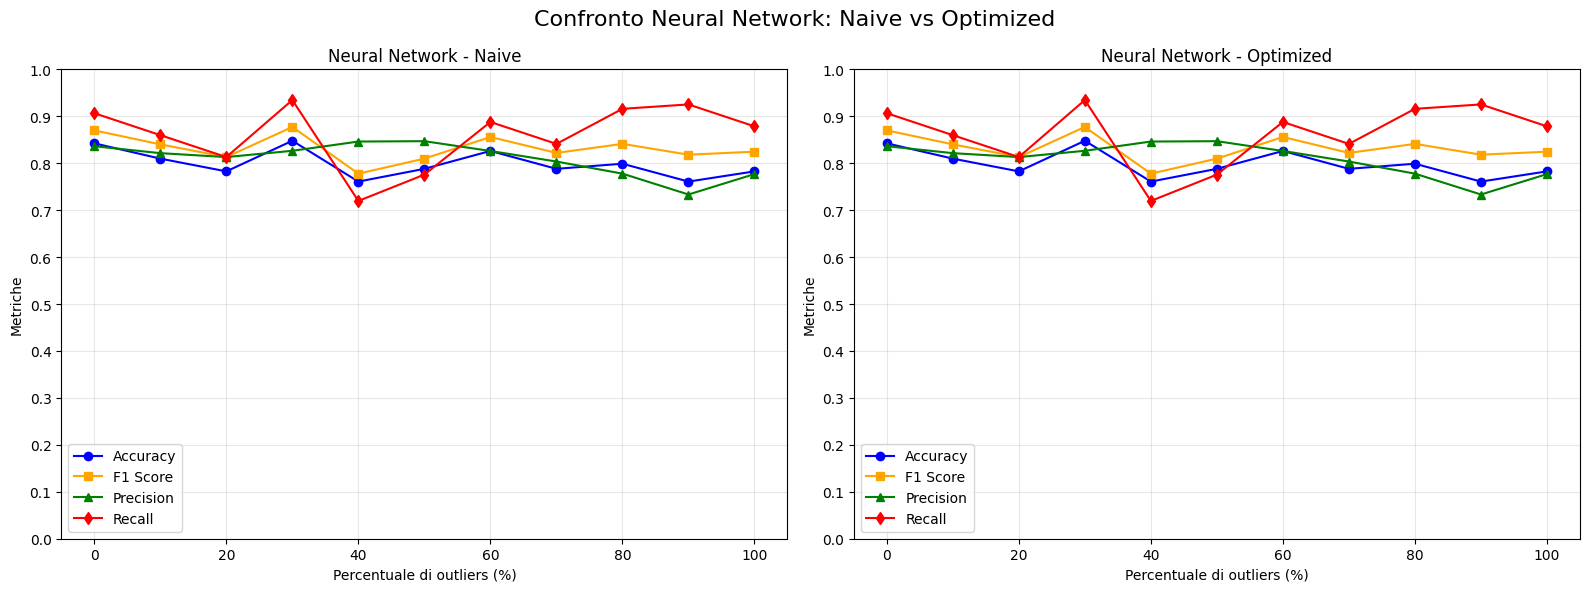

In [23]:
def plot_model_metrics_vs_contamination(all_metrics_outliers, contamination_history, 
                                        model_name, approach='Optimized', 
                                        figsize=(10, 6), save_path=None):
    """
    Crea un grafico delle metriche vs percentuale di contaminazione per un modello specifico
    
    Parameters:
    -----------
    all_metrics_outliers : list
        Lista con tutte le metriche raccolte
    contamination_history : list
        Storia della contaminazione con step e actual_rate
    model_name : str
        Nome del modello da plottare (es. 'Decision Tree', 'SVM', 'Neural Network')
    approach : str, default 'Optimized'
        Approccio da visualizzare ('Naive' o 'Optimized')
    figsize : tuple, default (10, 6)
        Dimensione della figura
    save_path : str, optional
        Path per salvare il grafico (se None, non salva)
    
    Returns:
    --------
    plt.Figure : La figura matplotlib creata
    """
    
    # Creo DataFrame da contamination_history
    contam_df = pd.DataFrame([
        {"step": h['step'], "contamination_rate": h['actual_rate']}
        for h in contamination_history
    ])
    
    # Aggiungo il caso iniziale (0% outliers) se non presente
    if 0 not in contam_df["step"].values:
        contam_df = pd.concat([
            pd.DataFrame([{"step": 0, "contamination_rate": 0.0}]),
            contam_df
        ], ignore_index=True)
    
    # Creo DataFrame delle metriche
    metrics_df = pd.DataFrame(all_metrics_outliers)
    
    # Merge su 'step'
    merged_df = pd.merge(metrics_df, contam_df, on="step", how="left")
    
    # Ordino i valori per contamination_rate
    merged_df = merged_df.sort_values("contamination_rate")
    
    # Filtro per il modello e approccio specifici
    filtered_df = merged_df[
        (merged_df["approach"] == approach) & 
        (merged_df["model"] == model_name)
    ]
    
    # Verifica che ci siano dati da plottare
    if filtered_df.empty:
        print(f"Nessun dato trovato per {model_name} - {approach}")
        return None
    
    # Crea il grafico
    plt.figure(figsize=figsize)
    
    # Plot delle metriche
    plt.plot(filtered_df["contamination_rate"]*100, filtered_df["accuracy"], 
             marker='o', color='blue', linewidth=2, markersize=6, label=f"{model_name} Accuracy")
    plt.plot(filtered_df["contamination_rate"]*100, filtered_df["f1_score"], 
             marker='s', color='orange', linewidth=2, markersize=6, label=f"{model_name} F1 Score")
    plt.plot(filtered_df["contamination_rate"]*100, filtered_df["precision"], 
             marker='^', color='green', linewidth=2, markersize=6, label=f"{model_name} Precision")
    plt.plot(filtered_df["contamination_rate"]*100, filtered_df["recall"], 
             marker='d', color='red', linewidth=2, markersize=6, label=f"{model_name} Recall")
    
    # Configurazione del grafico
    plt.xlabel("Percentuale di outliers nel dataset (%)", fontsize=12)
    plt.ylabel("Metriche sul test set", fontsize=12)
    plt.title(f"Andamento delle metriche con l'aumento degli outliers\n{model_name} - {approach}", fontsize=14)
    plt.yticks(np.arange(0, 1.1, 0.1))
    plt.xticks(np.arange(0, max(filtered_df["contamination_rate"]*100) + 10, 10))
    plt.grid(True, alpha=0.3)
    plt.legend(fontsize=10)
    
    # Migliora l'aspetto
    plt.tight_layout()
    
    plt.show()
    
    return plt.gcf()

plot_model_metrics_vs_contamination(
    all_metrics_outliers=all_metrics_outliers,
    contamination_history=contamination_history,
    model_name='Decision Tree',
    approach='Naive'
)

plot_model_metrics_vs_contamination(
    all_metrics_outliers=all_metrics_outliers,
    contamination_history=contamination_history,
    model_name='Decision Tree',
    approach='Optimized'
)

plot_model_metrics_vs_contamination(
    all_metrics_outliers=all_metrics_outliers,
    contamination_history=contamination_history,
    model_name='SVM',
    approach='Naive'
)

plot_model_metrics_vs_contamination(
    all_metrics_outliers=all_metrics_outliers,
    contamination_history=contamination_history,
    model_name='SVM',
    approach='Optimized'
)

plot_model_metrics_vs_contamination(
    all_metrics_outliers=all_metrics_outliers,
    contamination_history=contamination_history,
    model_name='Neural Network',
    approach='Naive'
)

plot_model_metrics_vs_contamination(
    all_metrics_outliers=all_metrics_outliers,
    contamination_history=contamination_history,
    model_name='Neural Network',
    approach='Optimized'
)

# 3. Confronto Naive vs Optimized per un modello
def plot_naive_vs_optimized(model_name):
    """Confronta approccio Naive vs Optimized per un modello"""
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))
    
    for i, approach in enumerate(['Naive', 'Optimized']):
        # Prepara dati
        contam_df = pd.DataFrame([
            {"step": h['step'], "contamination_rate": h['actual_rate']}
            for h in contamination_history
        ])
        
        if 0 not in contam_df["step"].values:
            contam_df = pd.concat([
                pd.DataFrame([{"step": 0, "contamination_rate": 0.0}]),
                contam_df
            ], ignore_index=True)
        
        metrics_df = pd.DataFrame(all_metrics_outliers)
        merged_df = pd.merge(metrics_df, contam_df, on="step", how="left")
        merged_df = merged_df.sort_values("contamination_rate")
        
        filtered_df = merged_df[
            (merged_df["approach"] == approach) & 
            (merged_df["model"] == model_name)
        ]
        
        # Plot su subplot
        axes[i].plot(filtered_df["contamination_rate"]*100, filtered_df["accuracy"], 
                    marker='o', color='blue', label="Accuracy")
        axes[i].plot(filtered_df["contamination_rate"]*100, filtered_df["f1_score"], 
                    marker='s', color='orange', label="F1 Score")
        axes[i].plot(filtered_df["contamination_rate"]*100, filtered_df["precision"], 
                    marker='^', color='green', label="Precision")
        axes[i].plot(filtered_df["contamination_rate"]*100, filtered_df["recall"], 
                    marker='d', color='red', label="Recall")
        
        axes[i].set_xlabel("Percentuale di outliers (%)")
        axes[i].set_ylabel("Metriche")
        axes[i].set_title(f"{model_name} - {approach}")
        axes[i].set_yticks(np.arange(0, 1.1, 0.1))
        axes[i].grid(True, alpha=0.3)
        axes[i].legend()
    
    plt.suptitle(f"Confronto {model_name}: Naive vs Optimized", fontsize=16)
    plt.xticks(np.arange(0,110,20))
    plt.tight_layout()
    plt.show()


plot_naive_vs_optimized('Decision Tree')
plot_naive_vs_optimized('SVM')
plot_naive_vs_optimized('Neural Network')

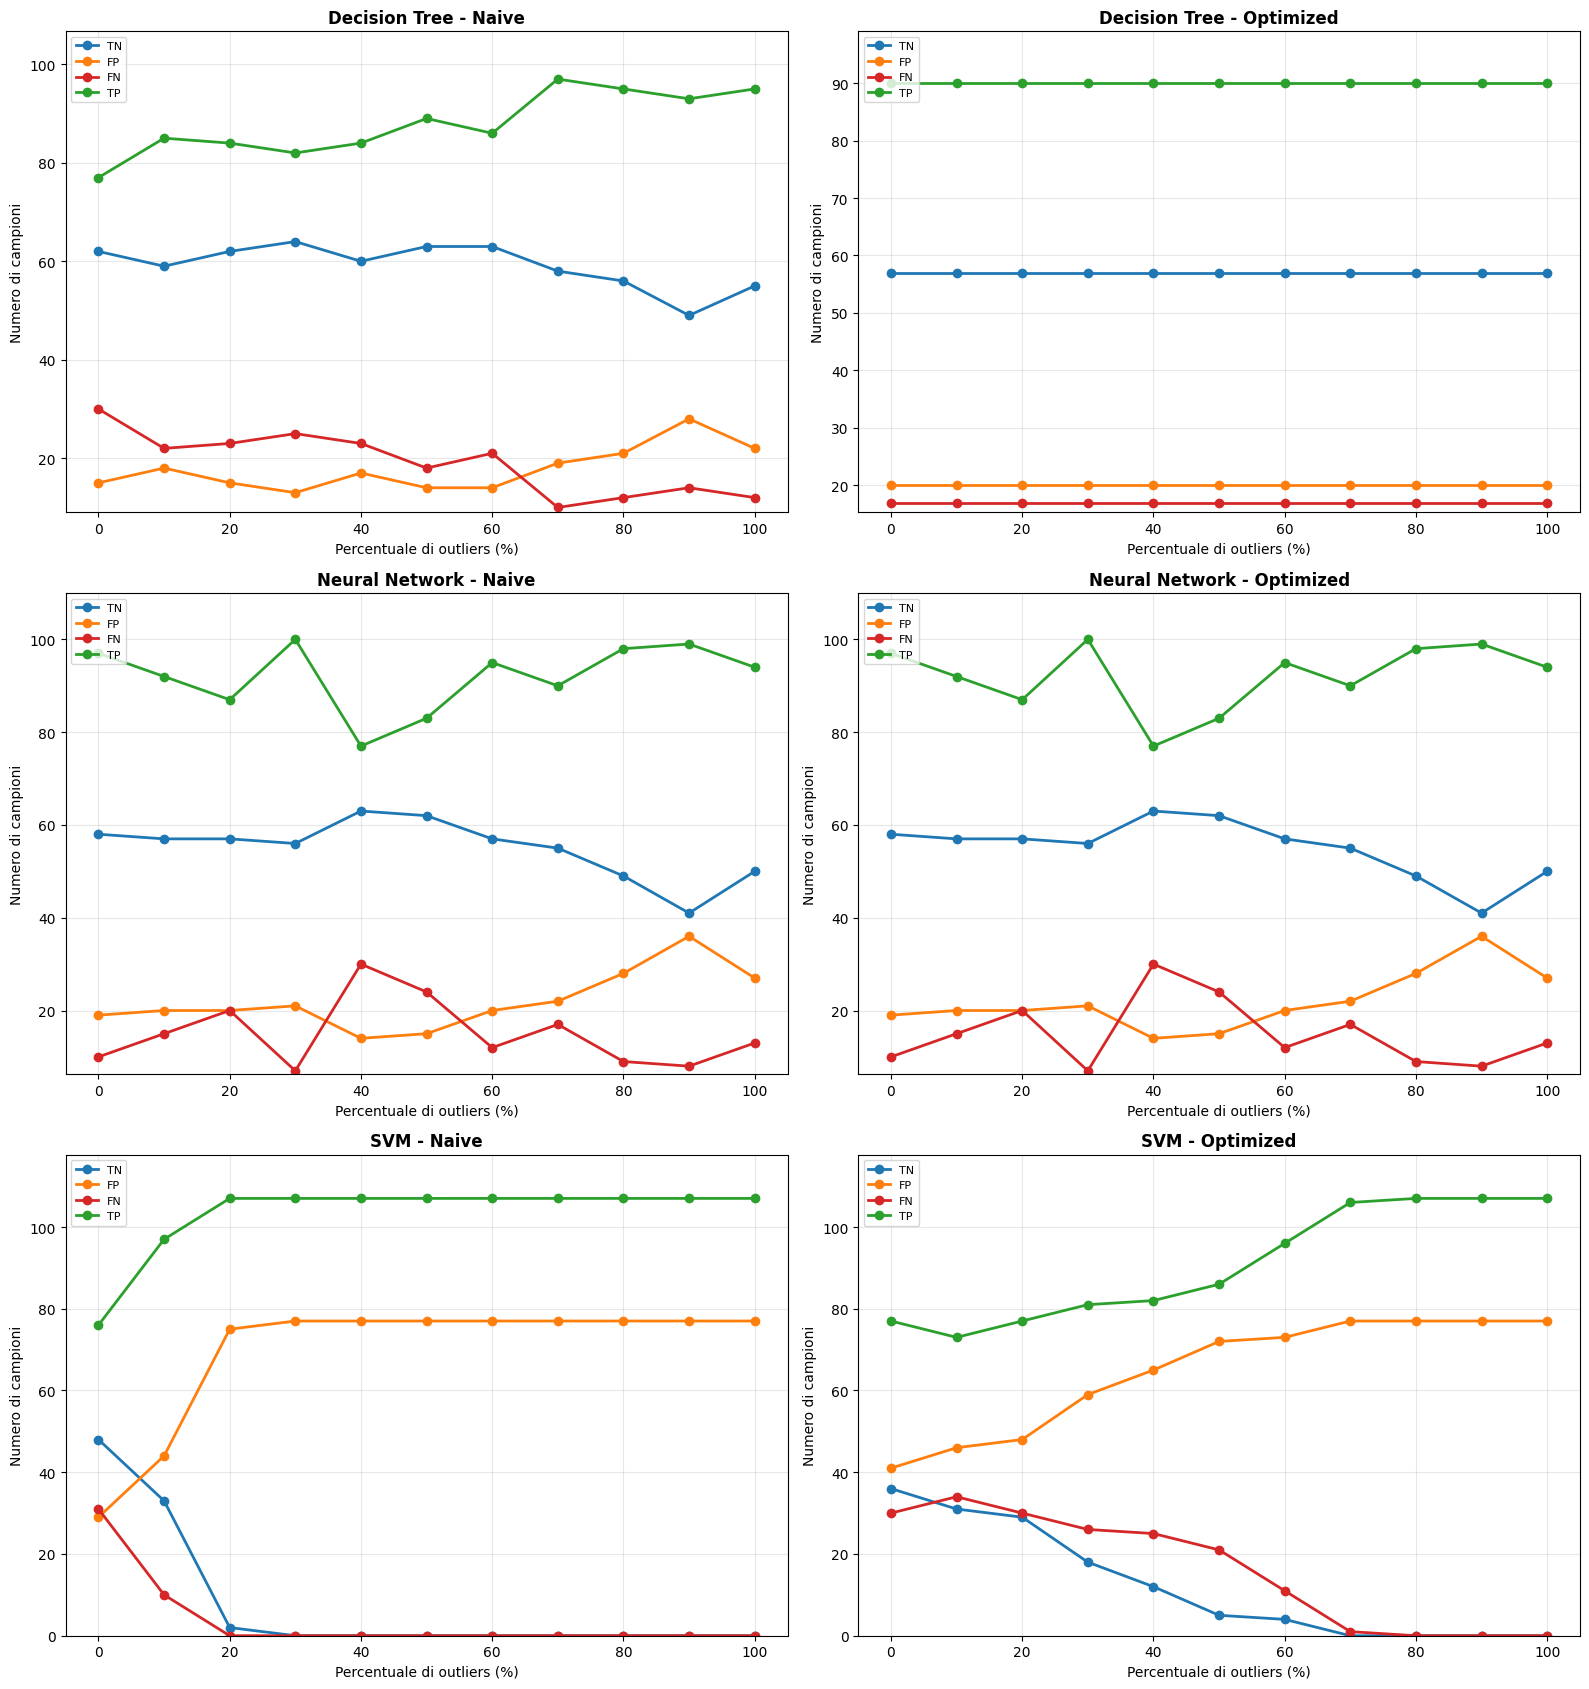

In [24]:
def plot_confusion_matrix_grid(confusion_matrix_values, contamination_history=None):
    """
    Crea una griglia di grafici 2 colonne x N righe (Naive | Optimized per modello)
    
    Parameters:
    -----------
    confusion_matrix_values : dict
        Dizionario con i valori delle confusion matrix
    contamination_history : list, optional
        Storia della contaminazione con step e actual_rate (default: usa step numerici)
    """
    
    # Estrai tutti i modelli unici (DT, SVM, NN)
    models = sorted(set(key.split(' - ')[0] for key in confusion_matrix_values.keys()))
    
    # Setup subplot: 2 colonne (Naive, Optimized), righe = numero modelli
    fig, axes = plt.subplots(len(models), 2, figsize=(16, 17))
    
    # Se c'è solo un modello, axes diventa 1D → forzo 2D
    if len(models) == 1:
        axes = [axes]
    
    colors = {
        'TN': '#1f77b4',  # blu
        'FP': '#ff7f0e',  # arancione  
        'FN': '#d62728',  # rosso
        'TP': '#2ca02c'   # verde
    }
    
    for model_idx, model in enumerate(models):
        for col_idx, approach in enumerate(["Naive", "Optimized"]):
            ax = axes[model_idx][col_idx]
            
            # Trova la chiave corretta (es: "Decision Tree - Naive")
            model_key = f"{model} - {approach}"
            if model_key not in confusion_matrix_values:
                continue
            
            # Estrai gli step
            steps = sorted(confusion_matrix_values[model_key].keys())
            
            if contamination_history is None:
                x_values = steps
                x_label = "Step"
            else:
                # mapping step -> contamination_rate
                contam_dict = {h['step']: h['actual_rate'] for h in contamination_history}
                if 0 not in contam_dict:
                    contam_dict[0] = 0.0
                x_values = [contam_dict.get(step, 0) * 100 for step in steps]
                x_label = "Percentuale di outliers (%)"
            
            # Estrai valori TN, FP, FN, TP
            metrics_data = {
                'TN': [confusion_matrix_values[model_key][step]['TN'] for step in steps],
                'FP': [confusion_matrix_values[model_key][step]['FP'] for step in steps],
                'FN': [confusion_matrix_values[model_key][step]['FN'] for step in steps],
                'TP': [confusion_matrix_values[model_key][step]['TP'] for step in steps]
            }
            
            # Plot linee
            for metric in ['TN', 'FP', 'FN', 'TP']:
                ax.plot(x_values, metrics_data[metric], 
                        color=colors[metric], 
                        marker='o',
                        linestyle='-',
                        label=metric,
                        linewidth=2,
                        markersize=6)
            
            # Personalizza subplot
            ax.set_title(f"{model} - {approach}", fontsize=12, fontweight='bold')
            ax.set_xlabel(x_label, fontsize=10)
            ax.set_ylabel("Numero di campioni", fontsize=10)
            ax.grid(True, alpha=0.3)
            ax.legend(fontsize=8, loc='upper left')
            
            # Limiti Y dinamici
            all_values = [v for metric in metrics_data.values() for v in metric]
            ax.set_ylim(min(all_values) * 0.9, max(all_values) * 1.1)
    
    plt.tight_layout()
    plt.show()

# Usa la funzione corretta
plot_confusion_matrix_grid(confusion_matrix_values, contamination_history)

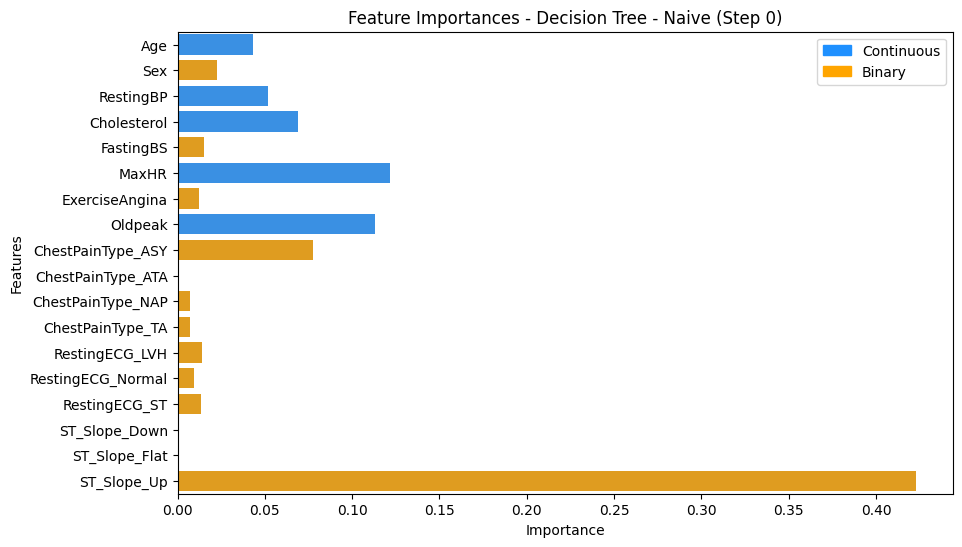

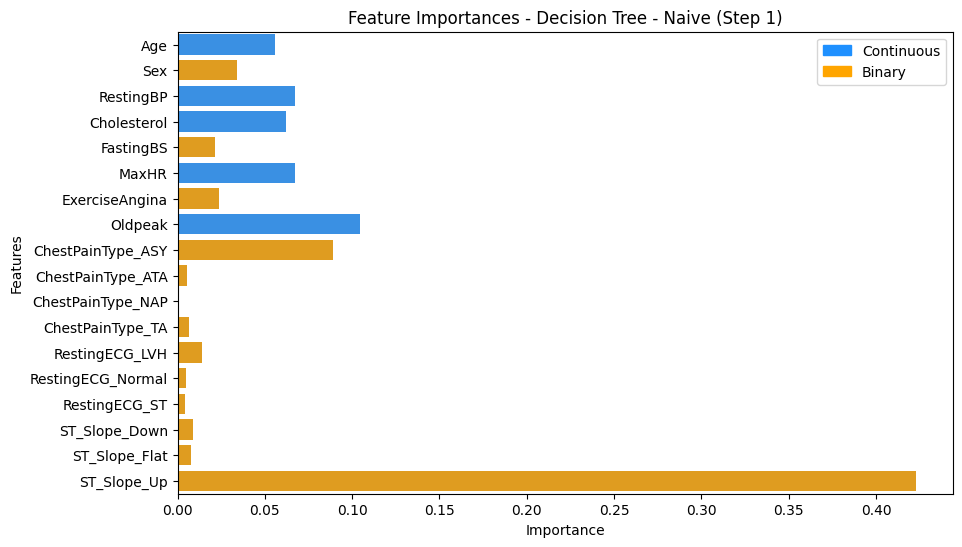

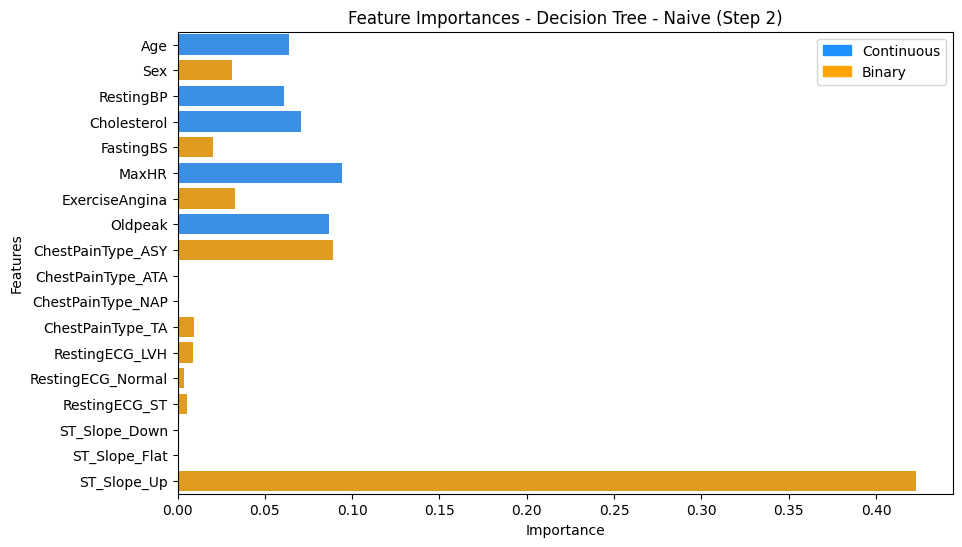

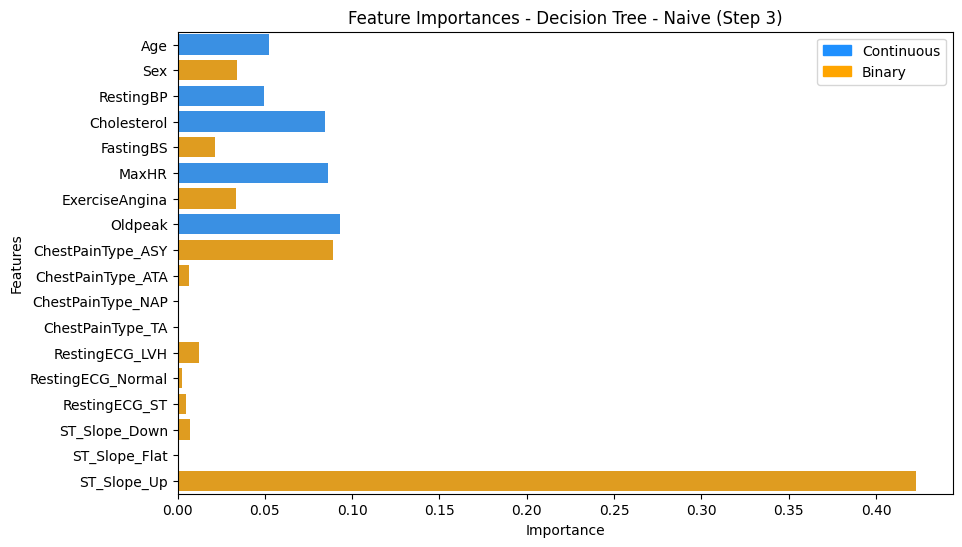

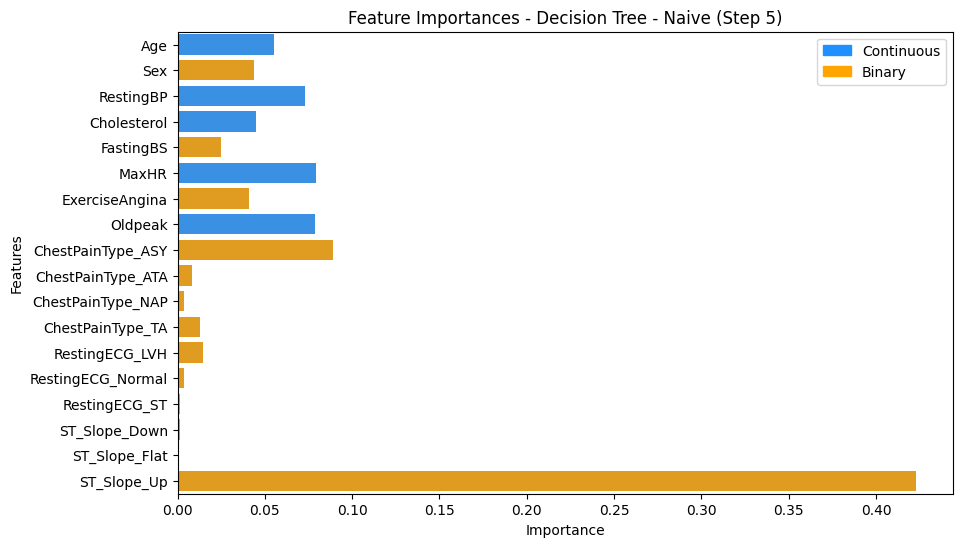

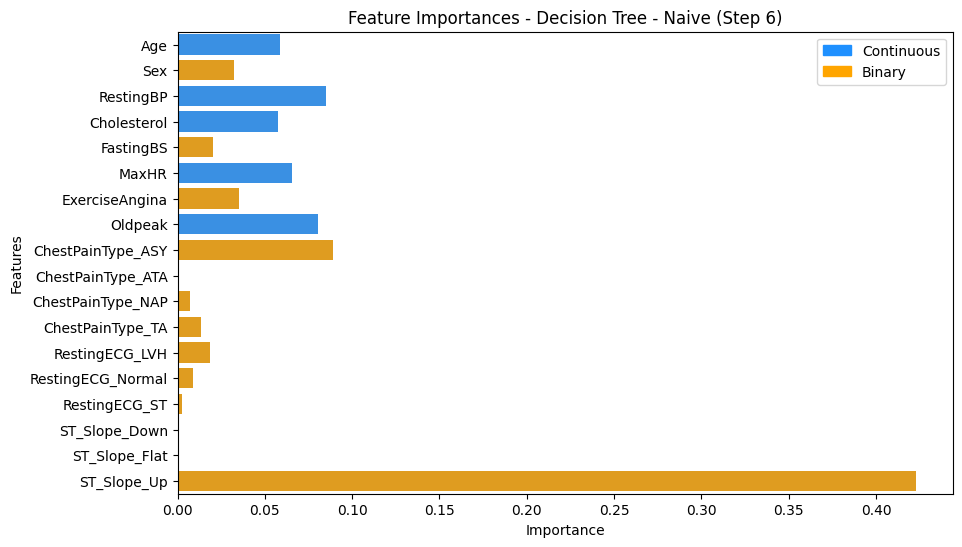

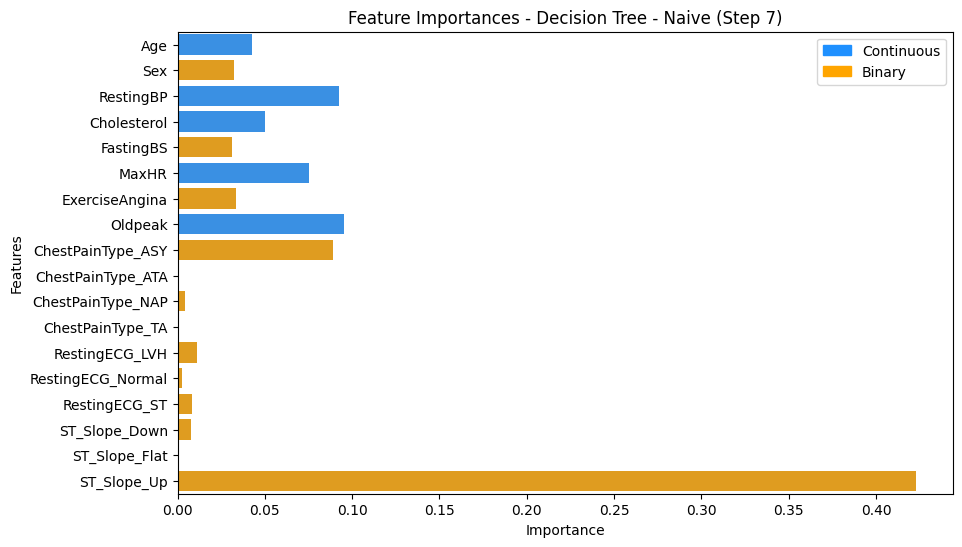

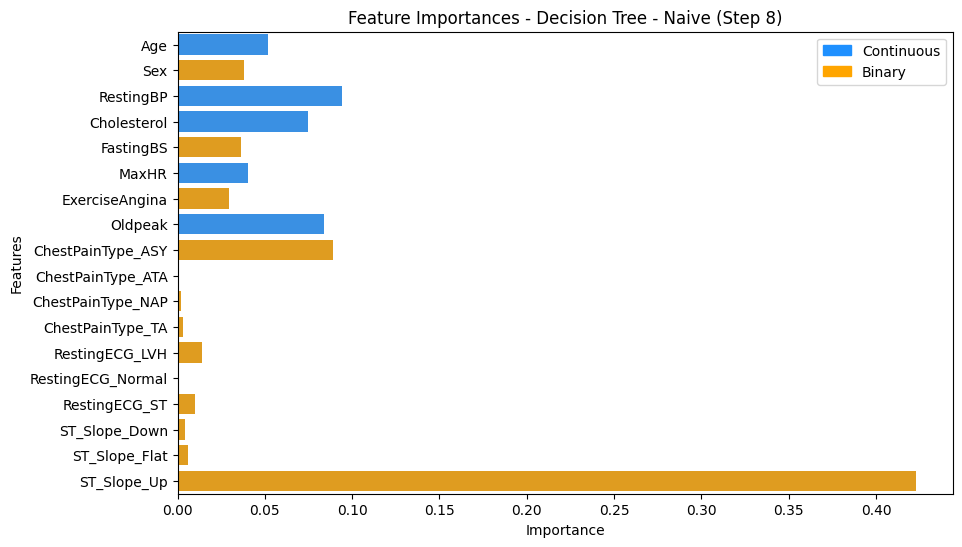

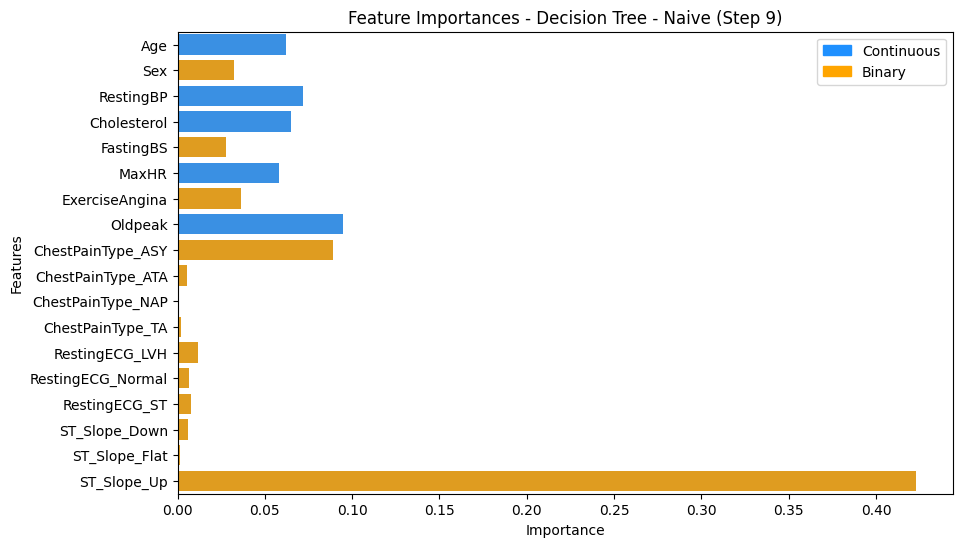

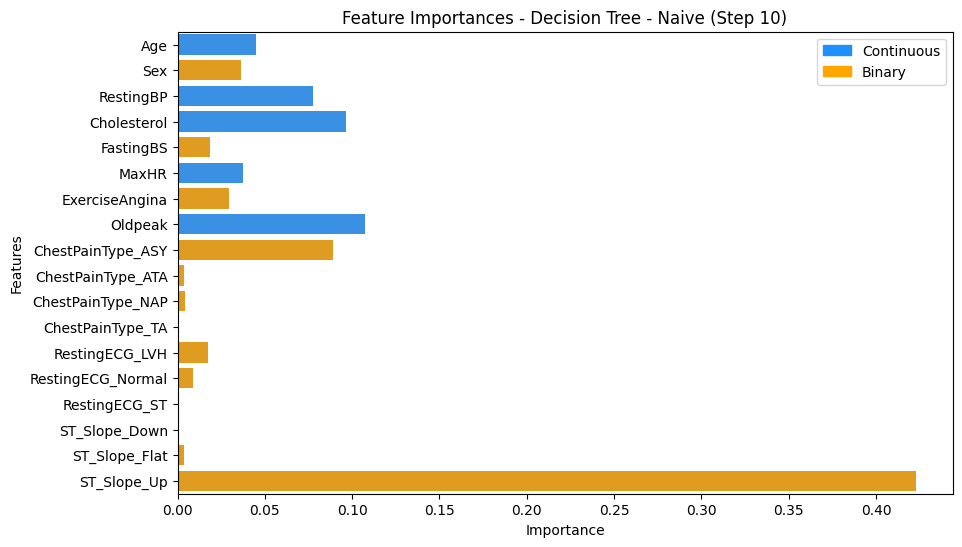

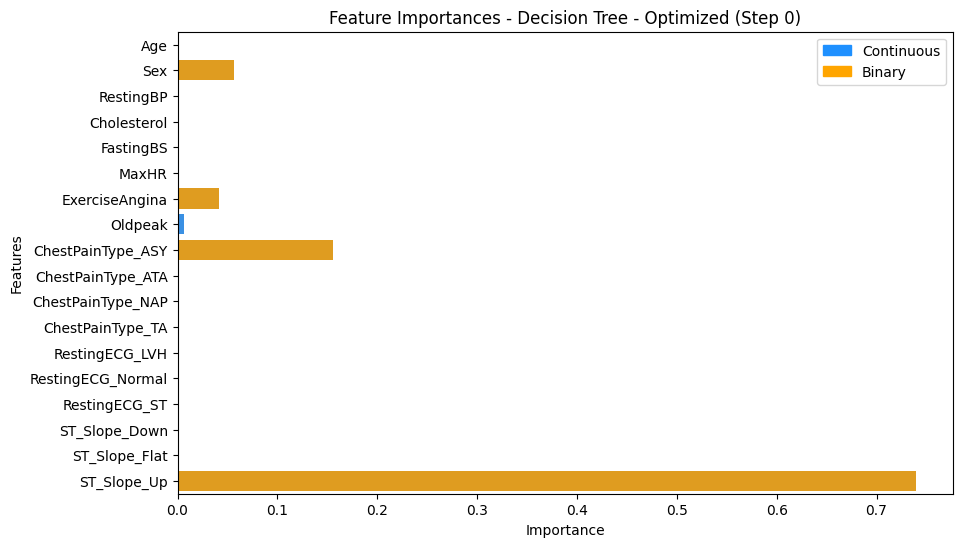

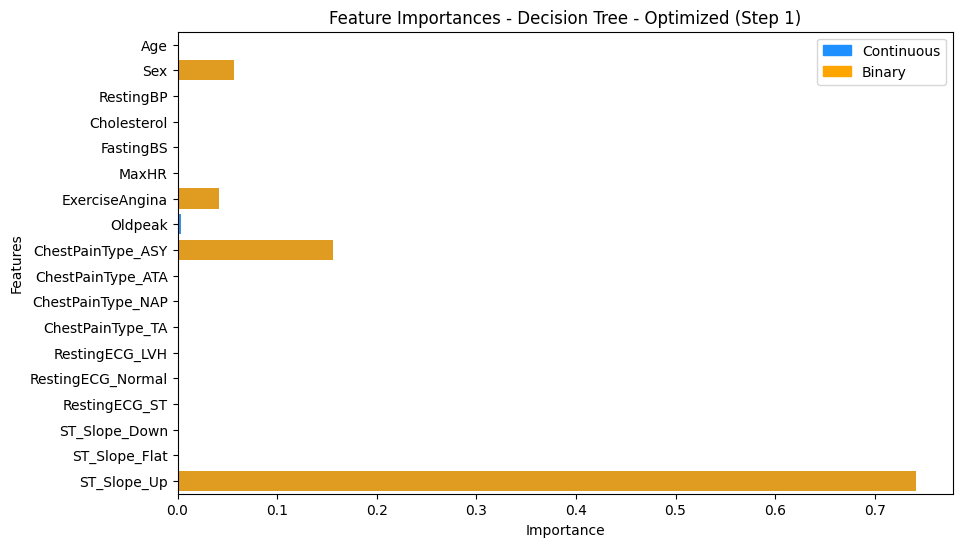

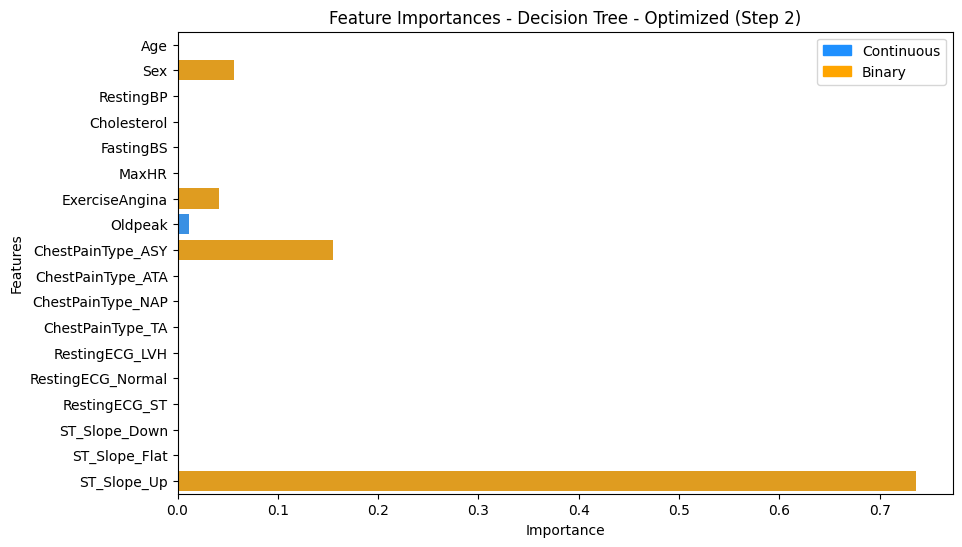

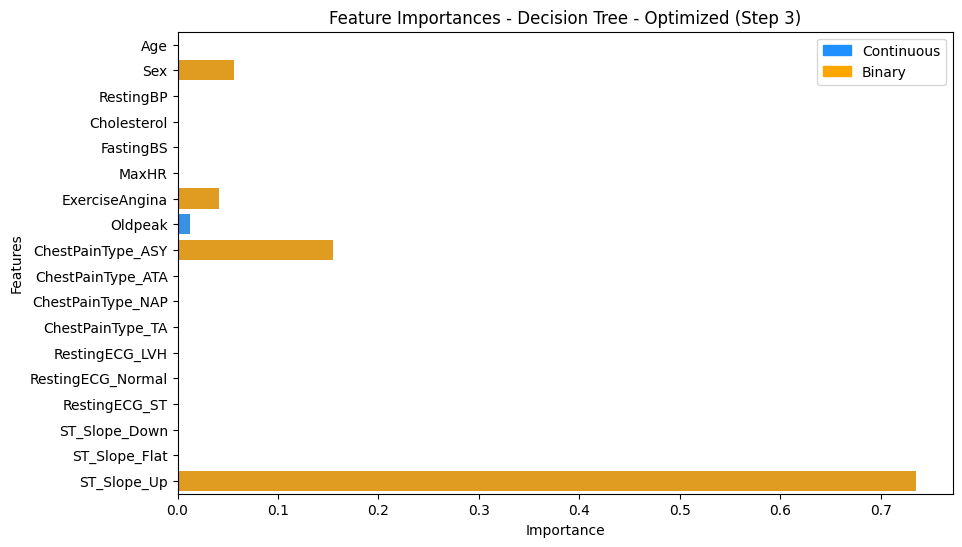

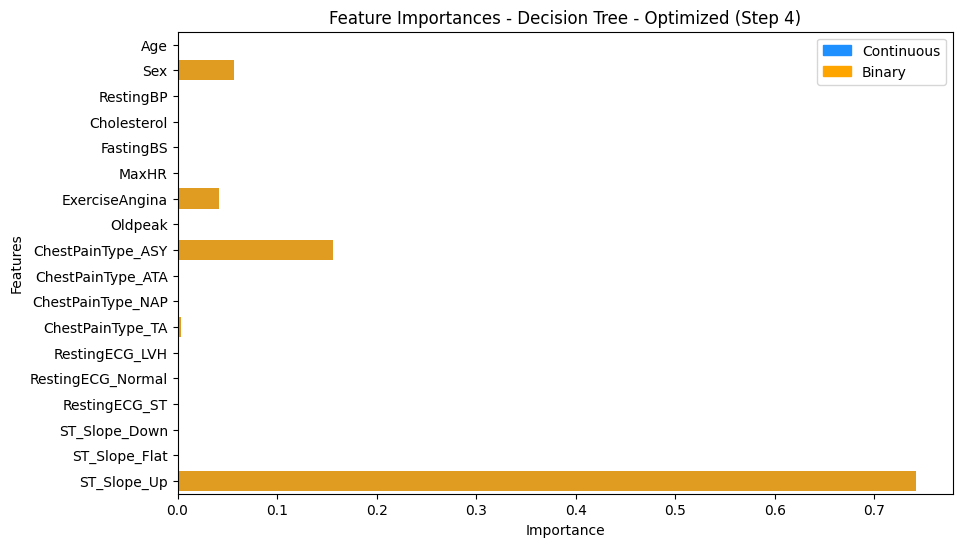

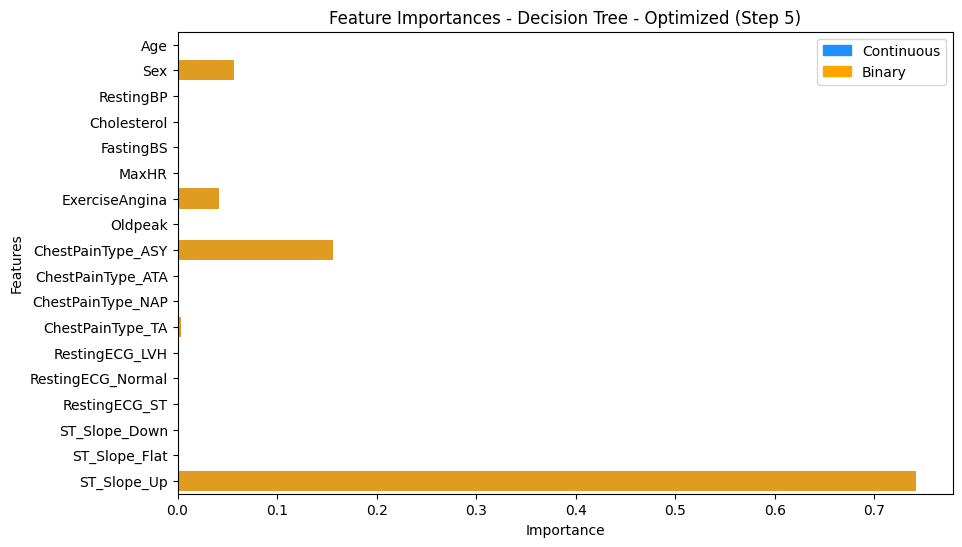

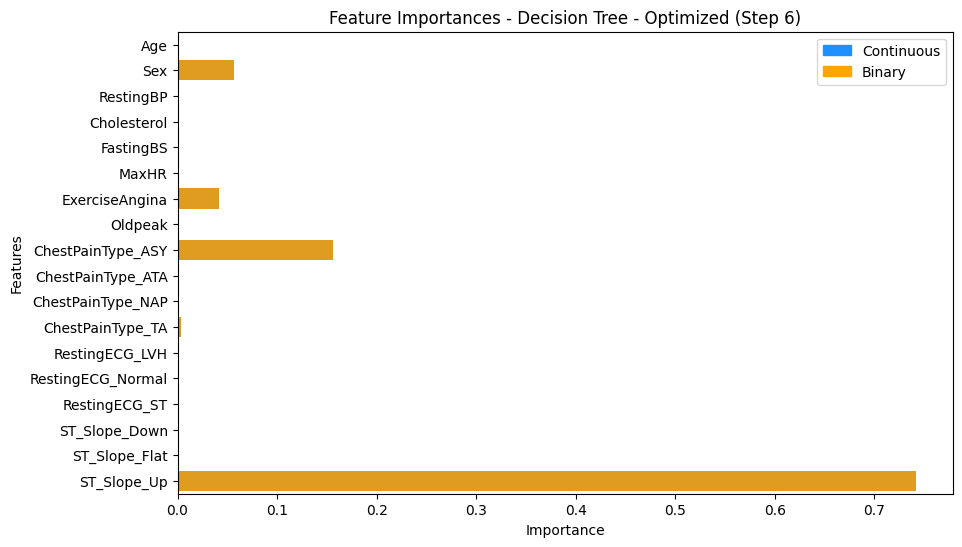

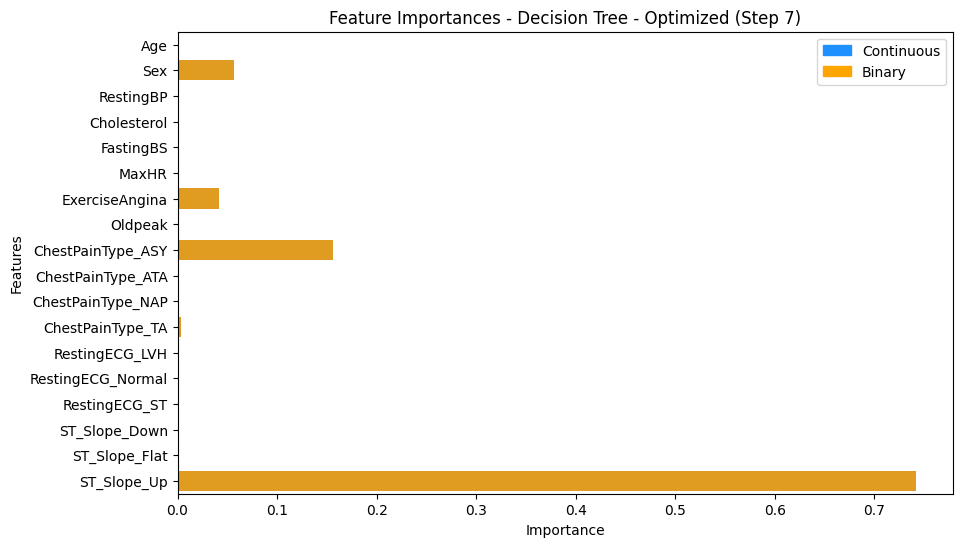

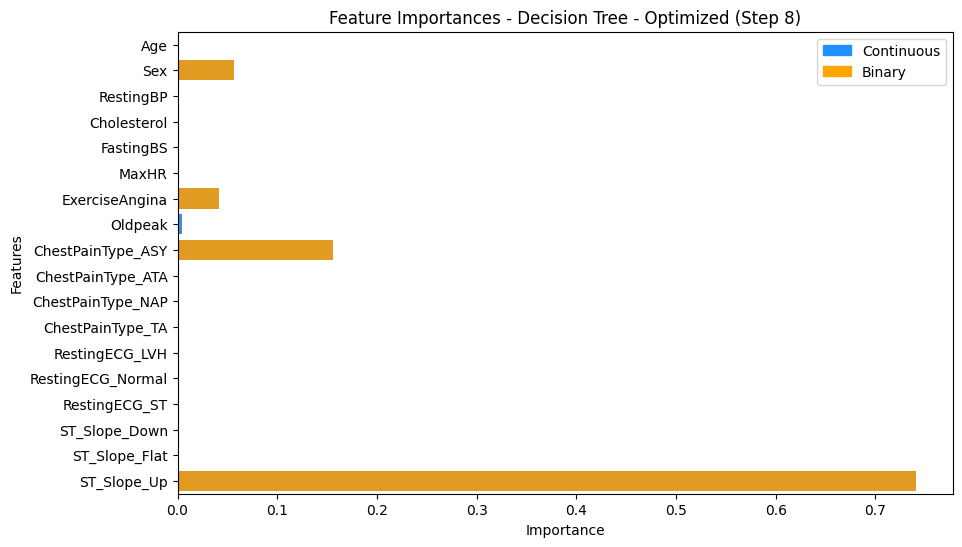

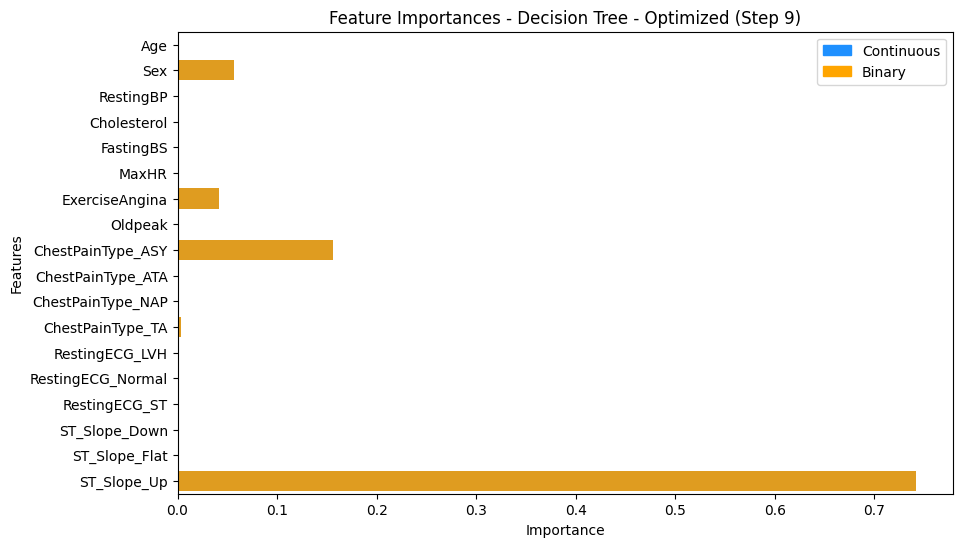

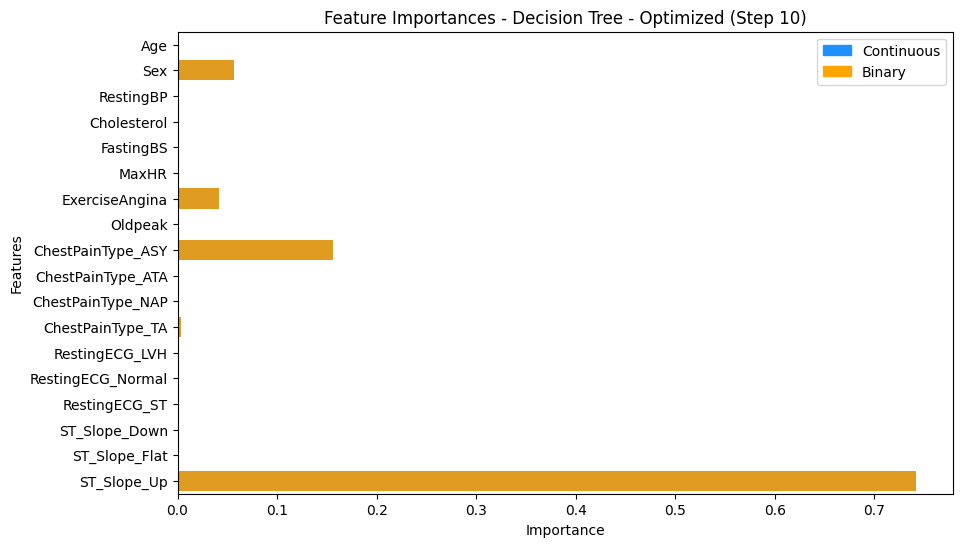

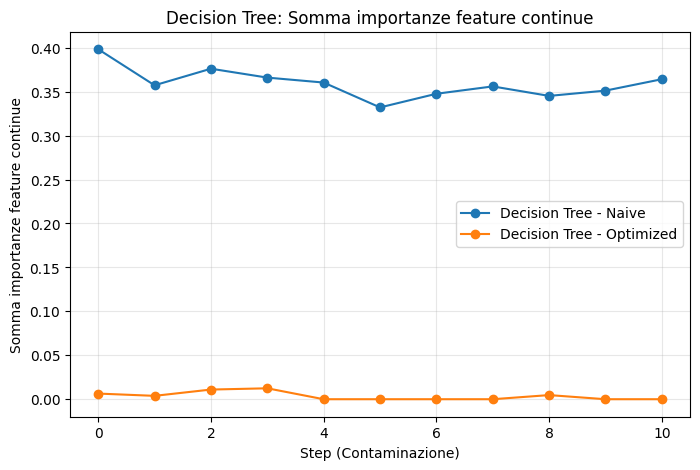

'\nplt.figure(figsize=(8, 5))\nfor key in feature_importances:\n    if "SVM" in key:\n        steps = []\n        sum_importances = []\n        for step, importances in feature_importances[key].items():\n            sum_continuous = sum(\n                imp for imp, feat in zip(importances, X_original.columns)\n                if feat in continuous_features\n            )\n            steps.append(step)\n            sum_importances.append(sum_continuous)\n        plt.plot(steps, sum_importances, marker=\'o\', label=key)\nplt.xlabel("Step (Contaminazione)")\nplt.ylabel("Somma importanze feature continue")\nplt.title("SVM: Somma importanze feature continue")\nplt.legend()\nplt.grid(True, alpha=0.3)\nplt.show()\n'

In [ ]:
import matplotlib.patches as mpatches

for key in feature_importances:
    for step, importances in feature_importances[key].items():
        plt.figure(figsize=(10, 6))
        feature_names = list(X_original.columns)
        colors = ['dodgerblue' if feat in continuous_features else 'orange' for feat in feature_names]
        sns.barplot(x=importances, y=feature_names, palette=colors)
        plt.title(f"Feature Importances - {key} (Step {step})")
        plt.xlabel("Importance")
        plt.ylabel("Features")
        blue_patch = mpatches.Patch(color='dodgerblue', label='Continuous')
        orange_patch = mpatches.Patch(color='orange', label='Binary')
        plt.legend(handles=[blue_patch, orange_patch])
        plt.show()

# Calcola la somma delle importanze delle feature continue per ogni step e approccio
# --- Decision Tree ---
plt.figure(figsize=(8, 5))
for key in feature_importances:
    if "Decision Tree" in key:
        steps = []
        sum_importances = []
        for step, importances in feature_importances[key].items():
            sum_continuous = sum(
                imp for imp, feat in zip(importances, X_original.columns)
                if feat in continuous_features
            )
            steps.append(step)
            sum_importances.append(sum_continuous)
        plt.plot(steps, sum_importances, marker='o', label=key)
plt.xlabel("Step (Contaminazione)")
plt.ylabel("Somma importanze feature continue")
plt.title("Decision Tree: Somma importanze feature continue")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- SVM ---
'''
plt.figure(figsize=(8, 5))
for key in feature_importances:
    if "SVM" in key:
        steps = []
        sum_importances = []
        for step, importances in feature_importances[key].items():
            sum_continuous = sum(
                imp for imp, feat in zip(importances, X_original.columns)
                if feat in continuous_features
            )
            steps.append(step)
            sum_importances.append(sum_continuous)
        plt.plot(steps, sum_importances, marker='o', label=key)
plt.xlabel("Step (Contaminazione)")
plt.ylabel("Somma importanze feature continue")
plt.title("SVM: Somma importanze feature continue")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()
'''

=== ANALISI DELL'IMPATTO DELLE FEATURE ===



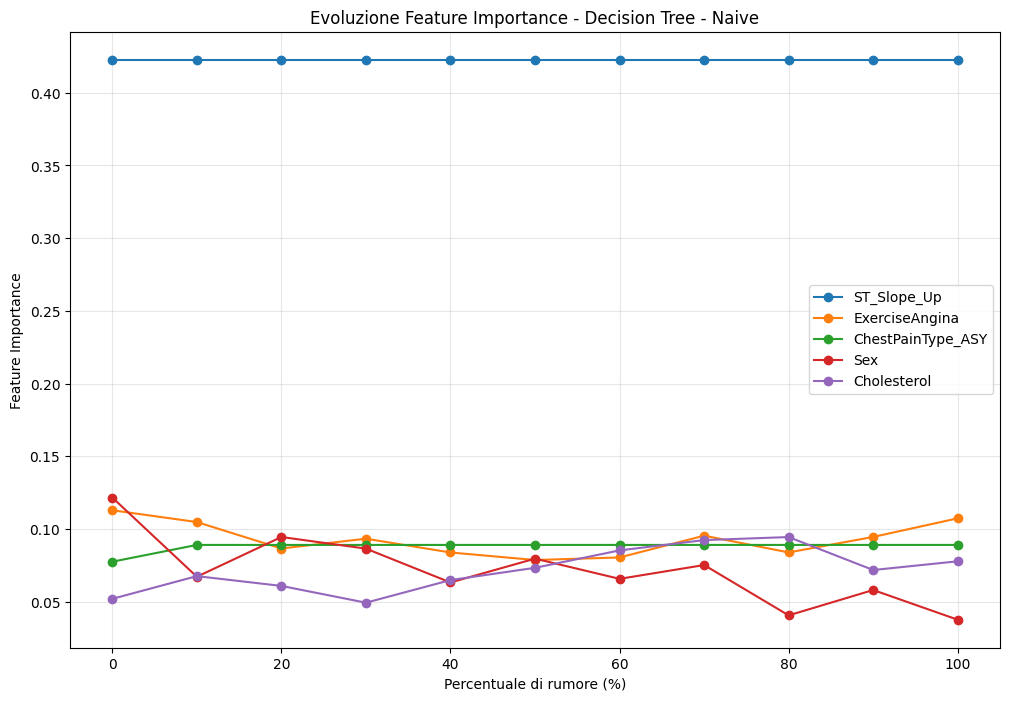


Decision Tree - Naive:
Media importanza feature continue: 0.0506
Media importanza feature binarie: 0.0574


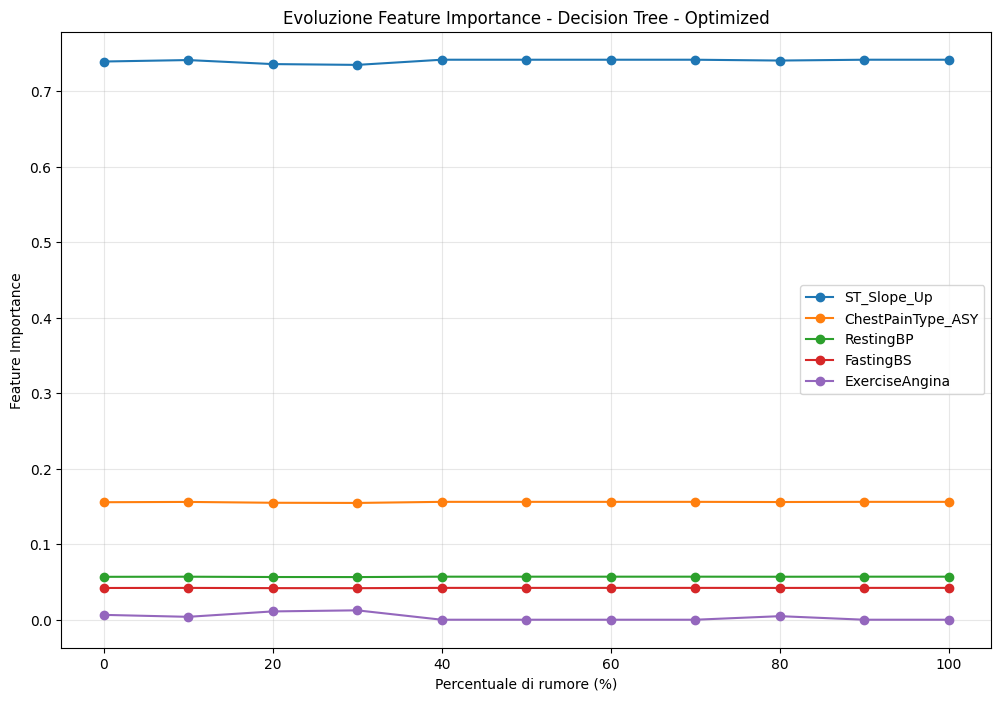


Decision Tree - Optimized:
Media importanza feature continue: 0.0114
Media importanza feature binarie: 0.0725


In [41]:
# %%
# ANALISI AGGIUNTIVE PER IL PROGETTO MISSING VALUES

from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.calibration import calibration_curve
import warnings
warnings.filterwarnings('ignore')

'''
# %%
# 4. ANALISI ROC E CALIBRAZIONE
def roc_calibration_analysis(all_metrics_duplicates, duplicated_dfs, X_test_clean, y_test_clean):
    """
    Analisi delle curve ROC e della calibrazione dei modelli
    """
    print("=== ANALISI ROC E CALIBRAZIONE ===\n")
    
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.svm import SVC
    from sklearn.neural_network import MLPClassifier
    from sklearn.model_selection import train_test_split
    from sklearn.impute import SimpleImputer
    from sklearn.calibration import CalibratedClassifierCV
    
    # Testa su alcuni step rappresentativi
    test_steps = [0.1, 0.3, 0.5]
    models_config = {
        'Decision Tree': DecisionTreeClassifier(),
        'SVM': SVC(probability=True),
        'Neural Network': MLPClassifier(max_iter=1000)
    }
    
    fig, axes = plt.subplots(len(test_steps), 3, figsize=(18, 6*len(test_steps)))
    if len(test_steps) == 1:
        axes = axes.reshape(1, -1)
    
    roc_results = []
    
    for step_idx, perc in enumerate(test_steps):
        if perc not in duplicated_dfs:
            continue

        df_degraded = duplicated_dfs[perc]
        X_contaminated = df_degraded.drop('HeartDisease', axis=1)
        y_contaminated = df_degraded['HeartDisease']
        
        X_train, _, y_train, _ = train_test_split(
            X_contaminated, y_contaminated, test_size=0.2, random_state=42
        )
        
        imputer = SimpleImputer(strategy='mean')
        X_train_imp = imputer.fit_transform(X_train)
        X_test_imp = imputer.transform(X_test_clean)
        
        for model_idx, (model_name, model) in enumerate(models_config.items()):
            model.fit(X_train_imp, y_train)
            
            if hasattr(model, "predict_proba"):
                y_proba = model.predict_proba(X_test_imp)[:, 1]
            else:
                y_proba = model.decision_function(X_test_imp)
            
            # ROC Curve
            fpr, tpr, _ = roc_curve(y_test_clean, y_proba)
            auc_score = roc_auc_score(y_test_clean, y_proba)
            
            axes[step_idx, model_idx].plot(fpr, tpr, label=f'ROC (AUC={auc_score:.3f})')
            axes[step_idx, model_idx].plot([0, 1], [0, 1], 'k--', alpha=0.5)
            axes[step_idx, model_idx].set_xlabel('False Positive Rate')
            axes[step_idx, model_idx].set_ylabel('True Positive Rate')
            axes[step_idx, model_idx].set_title(f'{model_name} - {int(perc*100)}% Missing')
            axes[step_idx, model_idx].legend()
            axes[step_idx, model_idx].grid(True, alpha=0.3)
            
            roc_results.append({
                'model': model_name,
                'missing_perc': perc,
                'auc_score': auc_score
            })
    
    plt.tight_layout()
    plt.show()
    
    return pd.DataFrame(roc_results)

'''

# %%
# 5. ANALISI DELL'IMPATTO SPECIFICO DELLE FEATURE
def feature_impact_analysis(feature_importances, continuous_features, binary_features):
    """
    Analizza come l'importanza delle feature cambia con l'aumento dei missing values
    """

    # Rimuovi la target dalle liste se presente
    continuous_features = [f for f in continuous_features if f != 'HeartDisease']
    binary_features = [f for f in binary_features if f != 'HeartDisease']

    print("=== ANALISI DELL'IMPATTO DELLE FEATURE ===\n")
    
    if not feature_importances:
        print("Nessuna feature importance disponibile")
        return
    
    # Solo per Decision Tree che ha feature_importances
    for model_approach, step_importances in feature_importances.items():
        if 'Decision Tree' not in model_approach:
            continue
            
        # Crea DataFrame delle importanze per step
        importance_data = []
        for step, importances in step_importances.items():
            # Verifica che importances sia un array/lista valida
            if importances is not None and len(importances) > 0:
                for feat_idx, importance in enumerate(importances):
                    importance_data.append({
                        'step': step,
                        'feature_idx': feat_idx,
                        'importance': importance
                    })
        
        if not importance_data:
            continue
            
        importance_df = pd.DataFrame(importance_data)
        
        # Visualizza l'evoluzione delle top 5 feature più importanti
        plt.figure(figsize=(12, 8))
        
        # Trova le top feature basate sull'importanza media
        avg_importance = importance_df.groupby('feature_idx')['importance'].mean().sort_values(ascending=False)
        top_features = avg_importance.head(5).index
        
        for feat_idx in top_features:
            feat_data = importance_df[importance_df['feature_idx'] == feat_idx].sort_values('step')
            # Ottieni il nome della feature corrispondente all'indice
            if feat_idx < len(continuous_features):
                feat_name = continuous_features[feat_idx]
            elif feat_idx < len(continuous_features) + len(binary_features):
                feat_name = binary_features[feat_idx - len(continuous_features)]
            else:
                feat_name = f"Feature {feat_idx}"
            plt.plot(feat_data['step']*10, feat_data['importance'], 
                    marker='o', label=feat_name)

        plt.xlabel('Percentuale di rumore (%)')
        plt.ylabel('Feature Importance')
        plt.title(f'Evoluzione Feature Importance - {model_approach}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        # Analisi separata per feature continue vs binarie (se hai i nomi delle feature)
        print(f"\n{model_approach}:")
        
        # Verifica che gli indici esistano prima di accedervi
        continuous_indices = [i for i in range(len(continuous_features)) if i in avg_importance.index]
        binary_start = len(continuous_features)
        binary_end = len(continuous_features) + len(binary_features)
        binary_indices = [i for i in range(binary_start, binary_end) if i in avg_importance.index]
        
        if continuous_indices:
            print(f"Media importanza feature continue: {avg_importance[continuous_indices].mean():.4f}")
        else:
            print("Nessuna feature continua trovata negli indici")
            
        if binary_indices:
            print(f"Media importanza feature binarie: {avg_importance[binary_indices].mean():.4f}")
        else:
            print("Nessuna feature binaria trovata negli indici")


# Esegui l'analisi comprehensive:
comprehensive_results = feature_impact_analysis(
    feature_importances, continuous_features, binary_features
)

   MI_numerical  MI_binary  perc_outliers
0      0.071235   0.105932            0.1
1      0.065632   0.105932            0.2
2      0.054234   0.105932            0.3
3      0.043910   0.105932            0.4
4      0.027278   0.105932            0.5
5      0.023075   0.105932            0.6
6      0.013550   0.105932            0.7
7      0.017436   0.105932            0.8
8      0.016553   0.105932            0.9
9      0.015081   0.105932            1.0


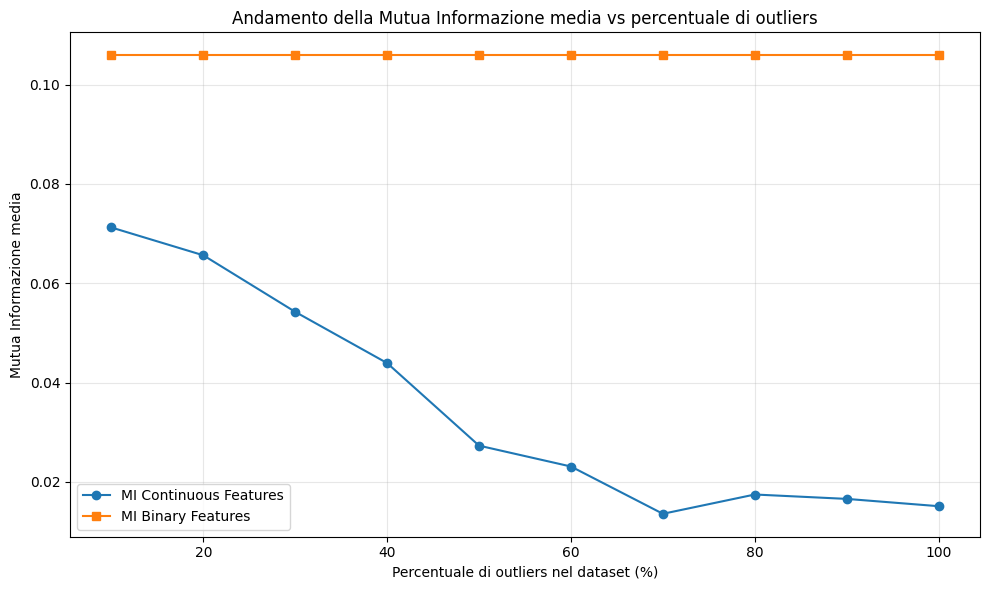

In [40]:
df_results = pd.DataFrame(mutua_informazione_feature)
print(df_results)

plt.figure(figsize=(10, 6))
plt.plot(df_results["perc_outliers"]*100, df_results["MI_numerical"], marker='o', label="MI Continuous Features")
plt.plot(df_results["perc_outliers"]*100, df_results["MI_binary"], marker='s', label="MI Binary Features")
plt.xlabel("Percentuale di outliers nel dataset (%)")
plt.ylabel("Mutua Informazione media")
plt.title("Andamento della Mutua Informazione media vs percentuale di outliers")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()